In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy

from joblib import load, dump

import model_functions as mf
import eval_measures as ems

from IPython.display import display

MF reloaded 1
EMS reloaded


In [2]:
sns.set_context("paper")
sns.set_style("ticks")

In [3]:
%%time
with pd.HDFStore('out/Training_2002_2005.h5') as cstore:
    df_first = cstore['first_author']
    df_last = cstore['last_author']
    
print df_first.shape, df_last.shape
df_first.columns

(41618369, 56) (41618369, 56)
CPU times: user 1min 12s, sys: 38.9 s, total: 1min 51s
Wall time: 1min 51s


In [4]:
df_first.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

## Load author years data

In [5]:
%%time
df_authors = pd.read_csv("data/AuthorityFirstLastYears.txt", sep="\t").rename(
    columns={"au_id": "auid"})
df_authors.shape

CPU times: user 7.82 s, sys: 1.15 s, total: 8.97 s
Wall time: 8.97 s


In [6]:
df_authors.head()

,auid,first_year,last_year
0,9731334_2,1997,2009
1,2155715_1,1990,2009
2,7867892_1,1994,2009
3,14609221_2,2003,2009
4,8101337_1,1993,2007


In [7]:
df_authors.dtypes

auid          object
first_year     int64
last_year      int64
dtype: object

In [8]:
df_authors.describe().astype(int)

,first_year,last_year
count,9300182,9300182
mean,1989,1994
std,16,15
min,1865,0
25%,1980,1986
50%,1994,2000
75%,2003,2007
max,9999,2099


In [9]:
df_authors[df_authors.first_year == 9999].shape, df_authors[df_authors.first_year <= 1900].shape

((3, 3), (3858, 3))

## Load author expertise data

In [10]:
%%time
df_expertise = pd.read_csv("data/AuthorExpertise.txt", sep="\t")
df_expertise.columns, df_expertise.shape

CPU times: user 59.8 s, sys: 5.68 s, total: 1min 5s
Wall time: 1min 5s


In [11]:
df_expertise.columns, df_expertise.shape

(Index([u'PMID', u'auid', u'match_len', u'match_prop', u'overall_coverage_len',
        u'overall_coverage_prop'],
       dtype='object'), (58761322, 6))

In [12]:
df_expertise.dtypes

PMID                       int64
auid                      object
match_len                  int64
match_prop               float64
overall_coverage_len       int64
overall_coverage_prop    float64
dtype: object

## First author

In [13]:
%%time
print df_first.shape
df_first = df_first.merge(df_authors, how="left", on="auid")
print df_first.shape

(41618369, 56)
(41618369, 58)
CPU times: user 1min 6s, sys: 34.9 s, total: 1min 41s
Wall time: 1min 41s


In [14]:
df_first["au_age"] = df_first["source_year"] - df_first["first_year"]

In [15]:
df_first.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

In [16]:
%%time
print df_first.shape
df_first = df_first.merge(df_expertise, how="left",
                          left_on=["source_id","auid"],
                          right_on=["PMID","auid"],)
print df_first.shape

(41618369, 59)
(41619240, 64)
CPU times: user 1min 1s, sys: 19.4 s, total: 1min 20s
Wall time: 1min 20s


In [17]:
df_first.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

In [18]:
%%time
df_first = df_first.drop("PMID", axis=1)
print df_first.shape

(41619240, 63)
CPU times: user 31.9 s, sys: 33.1 s, total: 1min 5s
Wall time: 1min 5s


## Last author

In [19]:
%%time
print df_last.shape
df_last = df_last.merge(df_authors, how="left", on="auid")
print df_last.shape

(41618369, 56)
(41618369, 58)
CPU times: user 1min 7s, sys: 36.8 s, total: 1min 44s
Wall time: 1min 44s


In [20]:
df_last["au_age"] = df_last["source_year"] - df_last["first_year"]

In [21]:
%%time
print df_last.shape
df_last = df_last.merge(df_expertise, how="left",
                          left_on=["source_id","auid"],
                          right_on=["PMID","auid"],)
print df_last.shape
df_last = df_last.drop("PMID", axis=1)
print df_last.shape

(41618369, 59)
(41619267, 64)
(41619267, 63)
CPU times: user 1min 33s, sys: 53.2 s, total: 2min 26s
Wall time: 2min 26s


## Modelling considerations

In [22]:
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
GENDERS = ["-", "F", "M"]

def prepare_data(df):
    df["eth_weight"] = 0.5 # Partial weight to multi ethnicity
    df.ix[df.eth2 == "UNKNOWN", "eth_weight"] = 1 # Full weight to single ethnicity
    df.ix[df.source_country == "-", "source_country"] = "UNKNOWN" # Set - to unknown
    df.source_country = df.source_country.astype("category", categories=TOP_15_COUNTRIES, ordered=False).fillna("OTHER")
    df.ix[df.eth1.isin(
        ["UNKNOWN", "TOOSHORT", "ERROR"]),
      "eth1"] = "UNKNOWN" # Set unknown ethnicities
    df.ix[df.eth2.isin(
            ["UNKNOWN", "TOOSHORT", "ERROR"]),
          "eth2"] = "UNKNOWN" # Set unknown ethnicities
    df.eth1 = df.eth1.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")
    df.eth2 = df.eth2.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")
    df.gender = df.gender.astype("category", categories=GENDERS, ordered=False).fillna("-")
    df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']] = df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']].astype("bool")

In [23]:
prepare_data(df_first)
prepare_data(df_last)

## Overall data statistics

### First author

In [24]:
%%time
df_t_first = df_first.pivot_table(index="gender", columns="is_self_cite",
               values=["source_year", u'source_n_mesh', u'source_is_eng', 
                       u'source_is_journal', u'source_is_review',
                       u'source_is_case_rep', u'source_is_let_ed_com',
                       u'source_T_novelty', u'source_V_novelty', u'source_PT_novelty',
                       u'source_PV_novelty', u'source_ncites', u'source_n_authors',
                       u'sink_year', u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng',
                       u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
                       u'sink_is_let_ed_com', u'sink_T_novelty', u'sink_V_novelty',
                       u'sink_PT_novelty', u'sink_PV_novelty', u'sink_n_authors',
                       u'year_span', u'journal_same',
                       u'mesh_sim', u'title_sim', u'lang_sim',
                       u'affiliation_sim', u'pubtype_sim', u'cite_sim', u'author_sim',
                       u'gender_sim', u'eth_sim', u'n_common_authors',
                       u'sink_last_ncites', u'sink_prev_ncites',
                       u'auth_last_npapers', u'auth_prev_papers',
                       u'au_age',
                       u'jj_sim', 
                       u'match_len', u'match_prop',
                       u'overall_coverage_len', u'overall_coverage_prop'
                      ],
                        aggfunc=[np.mean, np.std])
df_t_first

CPU times: user 1min 3s, sys: 41.4 s, total: 1min 45s
Wall time: 1min 45s


In [25]:
df_t_first.T.unstack(level=0).to_csv("First_Author_gender_self_cites_means.txt", sep="\t")

In [26]:
with pd.option_context('display.max_rows', 100,
                       'display.max_columns', 20,
                       'display.precision', 3
                      ):
    display(df_t_first.T.unstack(level=0))

gender                                     -                    F             \
                                        mean        std      mean        std   
                      is_self_cite                                             
source_year           0             2003.663      1.111  2003.631      1.112   
                      1             2003.635      1.114  2003.603      1.114   
source_n_mesh         0               13.492      5.859    13.340      5.463   
                      1               12.879      5.999    13.121      5.392   
source_is_eng         0                0.984      0.124     0.987      0.114   
                      1                0.995      0.072     0.992      0.091   
source_is_journal     0                0.990      0.099     0.990      0.100   
                      1                0.986      0.119     0.984      0.124   
source_is_review      0                0.137      0.344     0.192      0.394   
                      1                0.140      0.347     0.173      0.378   
source_is_case_rep    0                0.036      0.186     0.030      0.169   
                      1                0.011      0.107     0.012      0.107   
source_is_let_ed_com  0                0.010      0.100     0.010      0.101   
                      1                0.015      0.120     0.016      0.125   
source_T_novelty      0               19.846     12.504    20.965     12.666   
                      1               20.304     12.522    21.361     12.524   
source_V_novelty      0             3254.876  10964.931  3607.520  12431.366   
                      1             3298.214  11458.840  3632.428  24886.111   
source_PT_novelty     0                2.287      4.948     2.531      5.164   
                      1                2.333      4.960     2.540      5.089   
source_PV_novelty     0               12.492    678.392    24.137   1390.502   
                      1               19.853   1199.187    10.357    564.516   
source_ncites         0               45.780     66.675    53.320     94.552   
                      1               37.349     33.979    42.054     49.816   
source_n_authors      0                5.130      3.021     5.094      3.145   
                      1                5.176      4.281     5.183      3.538   
sink_year             0             1995.610      7.494  1995.628      7.401   
                      1             2000.468      3.569  2000.044      3.687   
sink_n_mesh           0               12.898      5.661    12.999      5.390   
                      1               13.219      6.051    13.518      5.356   
sink_n_mesh_ex        0               58.737     24.327    59.668     23.138   
                      1               60.834     26.808    62.792     23.686   
sink_is_eng           0                0.996      0.065     0.996      0.063   
                      1                0.995      0.068     0.995      0.073   
sink_is_journal       0                0.985      0.123     0.983      0.129   
                      1                0.989      0.105     0.988      0.108   
sink_is_review        0                0.146      0.353     0.148      0.355   
                      1                0.051      0.220     0.065      0.246   
sink_is_case_rep      0                0.030      0.171     0.028      0.166   
                      1                0.015      0.120     0.015      0.121   
sink_is_let_ed_com    0                0.016      0.124     0.017      0.130   
                      1                0.011      0.106     0.012      0.107   
sink_T_novelty        0               16.561     11.402    17.127     11.490   
                      1               18.326     11.820    19.033     11.811   
sink_V_novelty        0             2445.306   9045.168  2521.256   7979.934   
                      1             2514.894   6996.478  2669.978  12369.446   
sink_PT_novelty       0                1.786      4.393     1.853      4.443   


### Last author

In [27]:
df_t_last = df_last.pivot_table(index="gender", columns="is_self_cite",
               values=["source_year", u'source_n_mesh', u'source_is_eng', 
                       u'source_is_journal', u'source_is_review',
                       u'source_is_case_rep', u'source_is_let_ed_com',
                       u'source_T_novelty', u'source_V_novelty', u'source_PT_novelty',
                       u'source_PV_novelty', u'source_ncites', u'source_n_authors',
                       u'sink_year', u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng',
                       u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
                       u'sink_is_let_ed_com', u'sink_T_novelty', u'sink_V_novelty',
                       u'sink_PT_novelty', u'sink_PV_novelty', u'sink_n_authors',
                       u'year_span', u'journal_same',
                       u'mesh_sim', u'title_sim', u'lang_sim',
                       u'affiliation_sim', u'pubtype_sim', u'cite_sim', u'author_sim',
                       u'gender_sim', u'eth_sim', u'n_common_authors',
                       u'sink_last_ncites', u'sink_prev_ncites',
                       u'auth_last_npapers', u'auth_prev_papers',
                       u'au_age',
                       u'jj_sim',
                       u'match_len', u'match_prop',
                       u'overall_coverage_len', u'overall_coverage_prop'
                      ],
                        aggfunc=[np.mean, np.std])
df_t_last

mean                                                      \
              source_year              source_n_mesh            source_is_eng   
is_self_cite            0            1             0          1             0   
gender                                                                          
-             2003.668525  2003.669454     12.921061  13.370146      0.978522   
F             2003.634246  2003.616255     12.995463  13.705127      0.984779   
M             2003.597499  2003.589226     12.822445  13.196785      0.980800   

                                                                               \
                       source_is_journal           source_is_review             
is_self_cite         1                 0         1                0         1   
gender                                                                          
-             0.995681          0.986633  0.989529         0.171399  0.120635   
F             0.993584          0.986530  0.988157         0.231312  0.149486   
M             0.992040          0.985936  0.986839         0.227771  0.158791   

                ...            std                                    \
                ...         jj_sim              match_len              
is_self_cite    ...              0           1          0          1   
gender          ...                                                    
-               ...     107.418105  196.201352  26.964844  22.586342   
F               ...     112.664784  169.739193  24.640737  21.337889   
M               ...      91.100172  151.407318  22.974276  21.753687   

                                                                   \
             match_prop           overall_coverage_len              
is_self_cite          0         1                    0          1   
gender                                                              
-              0.321955  0.136271            23.582839  23.404009   
F              0.275971  0.119176            22.400058  22.330419   
M              0.209302  0.104821            22.484419  22.627888   

                                              
             overall_coverage_prop            
is_self_cite                     0         1  
gender                                        
-                         0.171760  0.097271  
F                         0.132850  0.079537  
M                         0.115065  0.075086  

[3 rows x 192 columns]

In [28]:
df_t_last.T.unstack(level=0).to_csv("Last_Author_gender_self_cites_means.txt", sep="\t")

In [29]:
with pd.option_context('display.max_rows', 100,
                       'display.max_columns', 20,
                       'display.precision', 3
                      ):
    display(df_t_last.T.unstack(level=0))

gender                                     -                    F             \
                                        mean        std      mean        std   
                      is_self_cite                                             
source_year           0             2003.669      1.110  2003.634      1.112   
                      1             2003.669      1.112  2003.616      1.114   
source_n_mesh         0               12.921      5.690    12.995      5.410   
                      1               13.370      6.102    13.705      5.576   
source_is_eng         0                0.979      0.145     0.985      0.122   
                      1                0.996      0.066     0.994      0.080   
source_is_journal     0                0.987      0.115     0.987      0.115   
                      1                0.990      0.102     0.988      0.108   
source_is_review      0                0.171      0.377     0.231      0.422   
                      1                0.121      0.326     0.149      0.357   
source_is_case_rep    0                0.046      0.210     0.032      0.176   
                      1                0.013      0.111     0.011      0.105   
source_is_let_ed_com  0                0.013      0.115     0.014      0.115   
                      1                0.011      0.104     0.012      0.110   
source_T_novelty      0               21.133     12.993    21.882     12.990   
                      1               19.388     12.091    19.907     12.071   
source_V_novelty      0             3534.550  11270.630  3773.758   8360.877   
                      1             3097.273  13115.467  3109.591   6873.506   
source_PT_novelty     0                2.593      5.319     2.810      5.526   
                      1                2.096      4.570     2.236      4.731   
source_PV_novelty     0               10.314    198.981    14.104    392.583   
                      1                9.777    329.167     9.857    358.987   
source_ncites         0               46.306     59.037    56.770     95.505   
                      1               39.348     36.907    44.151     40.060   
source_n_authors      0                5.176      3.610     4.827      3.125   
                      1                5.300      5.136     5.035      3.475   
sink_year             0             1995.291      7.777  1995.531      7.548   
                      1             1999.435      4.195  1998.849      4.363   
sink_n_mesh           0               12.621      5.579    12.843      5.349   
                      1               13.382      5.947    13.759      5.327   
sink_n_mesh_ex        0               57.827     24.093    59.082     22.996   
                      1               61.242     26.191    63.276     23.312   
sink_is_eng           0                0.995      0.073     0.996      0.065   
                      1                0.997      0.054     0.996      0.059   
sink_is_journal       0                0.982      0.132     0.981      0.135   
                      1                0.990      0.101     0.990      0.097   
sink_is_review        0                0.148      0.355     0.151      0.358   
                      1                0.062      0.242     0.076      0.265   
sink_is_case_rep      0                0.038      0.191     0.031      0.174   
                      1                0.013      0.114     0.012      0.111   
sink_is_let_ed_com    0                0.018      0.133     0.019      0.136   
                      1                0.010      0.101     0.010      0.098   
sink_T_novelty        0               17.273     11.708    17.633     11.678   
                      1               17.166     11.370    17.394     11.234   
sink_V_novelty        0             2529.759   9435.899  2578.390   7800.220   
                      1             2404.246   5600.294  2391.179  12136.882   
sink_PT_novelty       0                1.927      4.580     1.961      4.590   


## Preliminary Statistics

In [30]:
df_first.shape

(41619240, 64)

In [31]:
df_first.is_self_cite.mean()

0.048513836389131565

In [32]:
df_last.shape

(41619267, 64)

In [33]:
df_last.is_self_cite.mean()

0.08648619400240759

In [34]:
df_last.is_self_cite.value_counts()

0    38019775
1     3599492
Name: is_self_cite, dtype: int64

In [35]:
df_first.is_self_cite.value_counts()

0    39600131
1     2019109
Name: is_self_cite, dtype: int64

In [36]:
df_first[["gender", "is_self_cite"]].groupby("gender").is_self_cite.mean()* 100

gender
-    3.705023
F    3.779226
M    5.694023
Name: is_self_cite, dtype: float64

In [37]:
df_last[["gender", "is_self_cite"]].groupby("gender").is_self_cite.mean()* 100

gender
-    6.557432
F    7.179615
M    9.276608
Name: is_self_cite, dtype: float64

## Tables of gender self citation for age and prior papers

In [38]:
def filtered_data(df):
    # Base version 1
    df_filtered = df[(df.gender != "-")
                & (df.source_ncites >= 10)
                & (df.source_ncites <=60)]
    print df_filtered.shape, df.shape
    print "Filter dataset is %.2f%% of the original data." % (df_filtered.shape[0] * 100./df.shape[0])
    return df_filtered

def aggregate_function(x, median_col="auth_prev_papers", span=1):
    median = x[median_col].median()
    x = x[(x[median_col] >= (median - span))
         & (x[median_col] <= (median + span))]
    t = x.groupby("gender")["is_self_cite"].agg([np.mean, len])
    t["median"] = median
    return t

### First author

In [39]:
%%time
df_t_first = filtered_data(df_first)
display(df_t_first.pivot_table(index=pd.cut(df_t_first.au_age,
                                    bins=[4,6,8,12,18,22,27,33]),
                      columns="gender", values="is_self_cite", aggfunc=[np.mean, len]))

(26148675, 64) (41619240, 64)
Filter dataset is 62.83% of the original data.


mean                     len                      
gender      -         F         M   -          F          M
au_age                                                     
(4, 6]    NaN  0.039301  0.045931 NaN  1075897.0  1850463.0
(6, 8]    NaN  0.044391  0.053354 NaN   797698.0  1502238.0
(8, 12]   NaN  0.053800  0.063481 NaN  1037551.0  2141894.0
(12, 18]  NaN  0.068604  0.080691 NaN   881774.0  2023373.0
(18, 22]  NaN  0.080206  0.096689 NaN   361556.0   927872.0
(22, 27]  NaN  0.088466  0.109285 NaN   292644.0   863976.0
(27, 33]  NaN  0.096430  0.125897 NaN   189672.0   682763.0

CPU times: user 10.9 s, sys: 6.72 s, total: 17.6 s
Wall time: 17.6 s


In [40]:
df_t_first[["gender", "is_self_cite"]].groupby("gender").is_self_cite.mean()* 100

gender
-         NaN
F    3.962280
M    5.787288
Name: is_self_cite, dtype: float64

In [41]:
df_t_first.groupby(pd.cut(df_t_first.au_age,
                                    bins=[4,6,8,12,18,22,27,33])).auth_prev_papers.describe().to_frame().unstack()

auth_prev_papers                                                \
                    count       mean        std  min   25%   50%    75%   
au_age                                                                    
(4, 6]          2926360.0   8.735600   7.918158  1.0   4.0   7.0   11.0   
(6, 8]          2299936.0  13.070437  12.257853  1.0   6.0  10.0   16.0   
(8, 12]         3179445.0  19.852068  18.575819  1.0   8.0  15.0   25.0   
(12, 18]        2905147.0  33.785176  32.444887  1.0  13.0  24.0   43.0   
(18, 22]        1289428.0  50.750995  48.758790  1.0  19.0  37.0   66.0   
(22, 27]        1156620.0  68.638081  70.166317  1.0  26.0  49.0   88.0   
(27, 33]         872435.0  91.798813  93.371988  1.0  32.0  64.0  118.0   

                  
             max  
au_age            
(4, 6]     149.0  
(6, 8]     169.0  
(8, 12]    462.0  
(12, 18]   640.0  
(18, 22]   672.0  
(22, 27]  1167.0  
(27, 33]   996.0

In [42]:
df_t_first.groupby(pd.cut(df_t_first.au_age,
                                    bins=[0,1,2,3,4,6,8,12,18,22,27,33])).apply(aggregate_function).unstack()

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/pandas/indexes/category.py:118: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  data = Categorical(data, categories=categories, ordered=ordered)
/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/pandas/indexes/category.py:118: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  data = Categorical(data, categories=categories, ordered=ordered)


mean                     len                 median            
gender      -         F         M   -       F       M      -     F     M
au_age                                                                  
(0, 1]    NaN  0.017071  0.018470   0  672893  883693    1.0   1.0   1.0
(1, 2]    NaN  0.022868  0.024924   0  644699  838927    2.0   2.0   2.0
(2, 3]    NaN  0.029854  0.031049   0  408996  553894    3.0   3.0   3.0
(3, 4]    NaN  0.039952  0.040922   0  216412  328285    5.0   5.0   5.0
(4, 6]    NaN  0.044158  0.044623   0  242514  397329    7.0   7.0   7.0
(6, 8]    NaN  0.047341  0.050060   0  129466  222635   10.0  10.0  10.0
(8, 12]   NaN  0.058824  0.059643   0  104073  206110   15.0  15.0  15.0
(12, 18]  NaN  0.078402  0.074128   0   51874  115112   24.0  24.0  24.0
(18, 22]  NaN  0.091831  0.094580   0   13808   33654   37.0  37.0  37.0
(22, 27]  NaN  0.102627  0.099051   0    7347   22645   49.0  49.0  49.0
(27, 33]  NaN  0.114641  0.118494   0    3777   13891   64.0  64.0  64.0

In [43]:
df_t_first.groupby(pd.cut(df_t_first.au_age,
                                    bins=range(25))).apply(aggregate_function).unstack()

mean                     len                 median            
gender      -         F         M   -       F       M      -     F     M
au_age                                                                  
(0, 1]    NaN  0.017071  0.018470   0  672893  883693    1.0   1.0   1.0
(1, 2]    NaN  0.022868  0.024924   0  644699  838927    2.0   2.0   2.0
(2, 3]    NaN  0.029854  0.031049   0  408996  553894    3.0   3.0   3.0
(3, 4]    NaN  0.039952  0.040922   0  216412  328285    5.0   5.0   5.0
(4, 5]    NaN  0.041940  0.041381   0  158153  244486    6.0   6.0   6.0
(5, 6]    NaN  0.043040  0.043589   0  113965  182980    7.0   7.0   7.0
(6, 7]    NaN  0.047336  0.049195   0   75376  131395    9.0   9.0   9.0
(7, 8]    NaN  0.045909  0.052484   0   54804   98240   11.0  11.0  11.0
(8, 9]    NaN  0.052262  0.054095   0   42383   81264   12.0  12.0  12.0
(9, 10]   NaN  0.056391  0.055294   0   28267   58216   14.0  14.0  14.0
(10, 11]  NaN  0.058894  0.058481   0   23500   44442   16.0  16.0  16.0
(11, 12]  NaN  0.068008  0.064212   0   19880   34822   18.0  18.0  18.0
(12, 13]  NaN  0.068207  0.069794   0   15541   30318   20.0  20.0  20.0
(13, 14]  NaN  0.080898  0.071207   0   10025   24478   22.0  22.0  22.0
(14, 15]  NaN  0.081695  0.076336   0    8801   22008   25.0  25.0  25.0
(15, 16]  NaN  0.078823  0.078074   0    7853   17112   26.0  26.0  26.0
(16, 17]  NaN  0.082689  0.083403   0    6470   14436   28.0  28.0  28.0
(17, 18]  NaN  0.088354  0.084625   0    4199   12585   30.0  30.0  30.0
(18, 19]  NaN  0.099937  0.078418   0    4763   10648   33.0  33.0  33.0
(19, 20]  NaN  0.091979  0.096602   0    3740    8799   36.0  36.0  36.0
(20, 21]  NaN  0.101410  0.096034   0    3688    8195   38.0  38.0  38.0
(21, 22]  NaN  0.123810  0.093370   0    3150    6983   41.0  41.0  41.0
(22, 23]  NaN  0.089327  0.094742   0    2183    5668   44.0  44.0  44.0
(23, 24]  NaN  0.090399  0.101774   0    1604    5807   46.0  46.0  46.0

In [44]:
df_t = df_t_first.groupby(["auth_prev_papers", "gender"]).is_self_cite.agg([np.mean, len]).unstack()
df_t.head()

mean                  len           
gender                   F         M          F          M
auth_prev_papers                                          
0                 0.002630  0.002950  1508335.0  1698186.0
1                 0.013839  0.014609  1102301.0  1358766.0
2                 0.022141  0.022906   860697.0  1116372.0
3                 0.028143  0.029529   681661.0   936528.0
4                 0.032647  0.033089   551164.0   793562.0

In [45]:
df_t[df_t.index > 200].head()

mean              len        
gender                   F         M      F       M
auth_prev_papers                                   
201               0.132075  0.172092  159.0  3533.0
202               0.267647  0.226891  340.0  3927.0
203               0.168317  0.163998  101.0  4122.0
204               0.142045  0.147041  176.0  3278.0
205               0.151181  0.187476  635.0  2587.0

In [46]:
display(df_t_first.pivot_table(index=pd.cut(df_t_first.match_prop,
                                    bins=np.arange(0,1.1, 0.1)),
                      columns="gender", values="is_self_cite", aggfunc=[np.mean, len]))

mean                     len                      
gender        -         F         M   -          F          M
match_prop                                                   
(0, 0.1]    NaN  0.004069  0.005368 NaN    53329.0    68362.0
(0.1, 0.2]  NaN  0.004880  0.006203 NaN   170889.0   240850.0
(0.2, 0.3]  NaN  0.006989  0.008101 NaN   316214.0   441031.0
(0.3, 0.4]  NaN  0.010732  0.012003 NaN   487158.0   700750.0
(0.4, 0.5]  NaN  0.016126  0.017434 NaN   678922.0  1028072.0
(0.5, 0.6]  NaN  0.022847  0.024576 NaN   856422.0  1322024.0
(0.6, 0.7]  NaN  0.032174  0.034580 NaN  1085855.0  1796901.0
(0.7, 0.8]  NaN  0.045395  0.049450 NaN  1306052.0  2342643.0
(0.8, 0.9]  NaN  0.063754  0.072298 NaN  1342261.0  2872999.0
(0.9, 1]    NaN  0.102035  0.123153 NaN  1388735.0  4082615.0

In [47]:
df_t_first[["source_id", "gender", "match_prop"]].groupby("source_id").first().groupby("gender").mean()

,match_prop
gender,
F,0.560099
M,0.651669


### Last author

In [48]:
%%time
df_t_last = filtered_data(df_last)
display(df_t_last.pivot_table(index=pd.cut(df_t_last.au_age,
                                    bins=[4,6,8,12,18,22,27,33]),
                      columns="gender", values="is_self_cite", aggfunc=[np.mean, len]))

(27526723, 64) (41619267, 64)
Filter dataset is 66.14% of the original data.


mean                     len                      
gender      -         F         M   -          F          M
au_age                                                     
(4, 6]    NaN  0.043577  0.054559 NaN   245198.0   670691.0
(6, 8]    NaN  0.054254  0.068265 NaN   288087.0   913149.0
(8, 12]   NaN  0.068714  0.080418 NaN   713097.0  2403210.0
(12, 18]  NaN  0.084920  0.095047 NaN  1148708.0  4332862.0
(18, 22]  NaN  0.097655  0.105987 NaN   666520.0  2911318.0
(22, 27]  NaN  0.109483  0.113665 NaN   646299.0  3328608.0
(27, 33]  NaN  0.119224  0.123024 NaN   474820.0  3166102.0

CPU times: user 16.2 s, sys: 12.9 s, total: 29.1 s
Wall time: 29.1 s


In [49]:
df_t_last[["gender", "is_self_cite"]].groupby("gender").is_self_cite.mean()* 100

gender
-         NaN
F    7.834364
M    9.931546
Name: is_self_cite, dtype: float64

In [50]:
df_t_last.groupby(pd.cut(df_t_last.au_age,
                                    bins=[4,6,8,12,18,22,27,33])).auth_prev_papers.describe().to_frame().unstack()

auth_prev_papers                                                   \
                    count        mean         std  min   25%    50%    75%   
au_age                                                                       
(4, 6]           915889.0   12.139577   10.938851  1.0   5.0    9.0   16.0   
(6, 8]          1201236.0   19.737560   19.456762  1.0   8.0   15.0   25.0   
(8, 12]         3116307.0   31.511303   30.970875  1.0  14.0   23.0   39.0   
(12, 18]        5481570.0   52.363269   45.608768  1.0  24.0   40.0   66.0   
(18, 22]        3577838.0   78.718758   64.068521  1.0  36.0   61.0  102.0   
(22, 27]        3974907.0  106.866907   95.144210  1.0  48.0   82.0  134.0   
(27, 33]        3640922.0  136.860927  112.021429  1.0  63.0  107.0  176.0   

                  
             max  
au_age            
(4, 6]     103.0  
(6, 8]     371.0  
(8, 12]    545.0  
(12, 18]   640.0  
(18, 22]   672.0  
(22, 27]  1167.0  
(27, 33]  1359.0

In [51]:
df_t_last.groupby(pd.cut(df_t_last.au_age,
                                    bins=[0,1,2,3,4,6,8,12,18,22,27,33])).apply(aggregate_function).unstack()

mean                     len                median              
gender      -         F         M   -      F       M      -      F      M
au_age                                                                   
(0, 1]    NaN  0.012663  0.014134   0  92394  154800    1.0    1.0    1.0
(1, 2]    NaN  0.018248  0.019393   0  79132  142989    2.0    2.0    2.0
(2, 3]    NaN  0.031040  0.033840   0  38950   78191    4.0    4.0    4.0
(3, 4]    NaN  0.044148  0.046076   0  24463   58990    6.0    6.0    6.0
(4, 6]    NaN  0.049488  0.054344   0  41343  102200    9.0    9.0    9.0
(6, 8]    NaN  0.065949  0.070936   0  30827   88883   15.0   15.0   15.0
(8, 12]   NaN  0.074164  0.081661   0  46613  158166   23.0   23.0   23.0
(12, 18]  NaN  0.093752  0.096448   0  44479  170848   40.0   40.0   40.0
(18, 22]  NaN  0.103228  0.106392   0  18338   75316   61.0   61.0   61.0
(22, 27]  NaN  0.118308  0.113358   0  11301   60737   82.0   82.0   82.0
(27, 33]  NaN  0.159484  0.137148   0   5499   48065  107.0  107.0  107.0

In [52]:
df_t_last.groupby(pd.cut(df_t_last.au_age,
                                    bins=range(25))).apply(aggregate_function).unstack()

mean                     len                median            
gender      -         F         M   -      F       M      -     F     M
au_age                                                                 
(0, 1]    NaN  0.012663  0.014134   0  92394  154800    1.0   1.0   1.0
(1, 2]    NaN  0.018248  0.019393   0  79132  142989    2.0   2.0   2.0
(2, 3]    NaN  0.031040  0.033840   0  38950   78191    4.0   4.0   4.0
(3, 4]    NaN  0.044148  0.046076   0  24463   58990    6.0   6.0   6.0
(4, 5]    NaN  0.048195  0.050784   0  22637   53383    8.0   8.0   8.0
(5, 6]    NaN  0.050926  0.059258   0  19224   47926   10.0  10.0  10.0
(6, 7]    NaN  0.059010  0.063816   0  16099   45866   13.0  13.0  13.0
(7, 8]    NaN  0.065459  0.072830   0  14956   44844   16.0  16.0  16.0
(8, 9]    NaN  0.075830  0.079277   0  14783   48173   19.0  19.0  19.0
(9, 10]   NaN  0.065065  0.083231   0  12449   39168   22.0  22.0  22.0
(10, 11]  NaN  0.083855  0.080426   0  11663   39129   25.0  25.0  25.0
(11, 12]  NaN  0.074760  0.093647   0   9992   36584   28.0  28.0  28.0
(12, 13]  NaN  0.086575  0.091422   0   8663   34948   31.0  31.0  31.0
(13, 14]  NaN  0.086962  0.096403   0   7992   32385   34.0  34.0  34.0
(14, 15]  NaN  0.099392  0.090820   0   9045   30654   38.0  38.0  38.0
(15, 16]  NaN  0.097702  0.093341   0   7093   27705   42.0  42.0  42.0
(16, 17]  NaN  0.102696  0.104670   0   6602   24391   46.0  46.0  46.0
(17, 18]  NaN  0.099453  0.100758   0   5480   24266   51.0  51.0  51.0
(18, 19]  NaN  0.113051  0.105487   0   4352   22818   54.0  54.0  54.0
(19, 20]  NaN  0.113076  0.104730   0   4864   18753   59.0  59.0  59.0
(20, 21]  NaN  0.102139  0.112132   0   3319   17301   64.0  64.0  64.0
(21, 22]  NaN  0.102107  0.103948   0   3369   16643   68.0  68.0  68.0
(22, 23]  NaN  0.127448  0.128132   0   3217   15086   72.0  72.0  72.0
(23, 24]  NaN  0.130902  0.117569   0   2605   12010   78.0  78.0  78.0

In [53]:
df_t = df_t_last.groupby(["auth_prev_papers", "gender"]).is_self_cite.agg([np.mean, len]).unstack()
df_t.head()

mean                 len          
gender                   F         M         F         M
auth_prev_papers                                        
0                 0.001768  0.002221  354618.0  520850.0
1                 0.009851  0.010922  174400.0  293266.0
2                 0.017412  0.018043  124628.0  231498.0
3                 0.021854  0.022842  104605.0  211282.0
4                 0.027933  0.028851   96515.0  203803.0

In [54]:
df_t[df_t.index > 200].head()

mean               len         
gender                   F         M       F        M
auth_prev_papers                                     
201               0.169872  0.139676  1248.0  24972.0
202               0.208205  0.133783   975.0  23740.0
203               0.120042  0.139193   958.0  21560.0
204               0.169231  0.142836  1885.0  19883.0
205               0.166667  0.141209  1686.0  23582.0

In [55]:
display(df_t_last.pivot_table(index=pd.cut(df_t_last.match_prop,
                                    bins=np.arange(0,1.1, 0.1)),
                      columns="gender", values="is_self_cite", aggfunc=[np.mean, len]))

mean                     len                       
gender        -         F         M   -          F           M
match_prop                                                    
(0, 0.1]    NaN  0.004332  0.007531 NaN     9925.0     17794.0
(0.1, 0.2]  NaN  0.005513  0.008563 NaN    28115.0     60377.0
(0.2, 0.3]  NaN  0.005923  0.009147 NaN    59427.0    130209.0
(0.3, 0.4]  NaN  0.008838  0.012541 NaN    97421.0    229974.0
(0.4, 0.5]  NaN  0.014203  0.018079 NaN   159619.0    400792.0
(0.5, 0.6]  NaN  0.023015  0.027089 NaN   242711.0    679087.0
(0.6, 0.7]  NaN  0.037999  0.039974 NaN   409853.0   1277263.0
(0.7, 0.8]  NaN  0.057539  0.059966 NaN   731955.0   2607622.0
(0.8, 0.9]  NaN  0.083113  0.087707 NaN  1201356.0   5074137.0
(0.9, 1]    NaN  0.125788  0.136504 NaN  1930062.0  10960109.0

In [56]:
df_t_last[["source_id", "gender", "match_prop"]].groupby("source_id").first().groupby("gender").mean()

,match_prop
gender,
F,0.732513
M,0.822449


## Plot author age and self-citation

In [57]:
def get_lower_quantile(x):
    return pd.Series.quantile(x, q=0.05)
    
def get_upper_quantile(x):
    return pd.Series.quantile(x, q=0.95)


def mean_confidence_interval(data, confidence=0.95):
    from scipy import stats
    a = data*1.0
    n = len(a)
    m, se = a.mean(), stats.sem(a)
    h = se * stats.t._ppf((1+confidence)/2., n-1)
    return pd.Series([m, m-h, m+h], index=["mean", "ci_l", "ci_u"])

In [58]:
mean_confidence_interval(np.random.randn(100))

mean   -0.141473
ci_l   -0.335985
ci_u    0.053040
dtype: float64

In [59]:
df_t_first.head(1000).groupby(["auth_prev_papers", "gender"]
                             ).match_prop.agg([
        pd.Series.median, pd.Series.count,
        get_lower_quantile, get_upper_quantile
    ]).unstack()

median           count        get_lower_quantile  \
gender                   F         M     F      M                  F   
auth_prev_papers                                                       
0                 0.000000  0.000000  58.0   62.0           0.000000   
1                 0.549296  0.504951  73.0   36.0           0.296000   
2                 0.592105  0.314286  35.0   30.0           0.592105   
3                      NaN  0.383721   NaN  109.0                NaN   
4                 0.677419       NaN  10.0    NaN           0.677419   
5                      NaN  0.660870   NaN   69.0                NaN   
6                 0.702128       NaN  17.0    NaN           0.702128   
7                 0.774194       NaN  39.0    NaN           0.774194   
11                     NaN  0.578512   NaN   62.0                NaN   
12                     NaN  0.605263   NaN   47.0                NaN   
14                0.918919       NaN  75.0    NaN           0.918919   
16                0.884615       NaN  40.0    NaN           0.884615   
20                     NaN  1.000000   NaN   25.0                NaN   
26                     NaN  1.000000   NaN   43.0                NaN   
75                     NaN  1.000000   NaN   20.0                NaN   
126                    NaN  1.000000   NaN   50.0                NaN   
129                    NaN  0.962963   NaN   18.0                NaN   
146                    NaN  1.000000   NaN   18.0                NaN   
156                    NaN  1.000000   NaN   32.0                NaN   
178               1.000000       NaN  32.0    NaN           1.000000   

                           get_upper_quantile            
gender                   M                  F         M  
auth_prev_papers                                         
0                 0.000000           0.000000  0.000000  
1                 0.504951           0.549296  0.504951  
2                 0.314286           0.592105  0.314286  
3                 0.380282                NaN  0.636364  
4                      NaN           0.677419       NaN  
5                 0.625000                NaN  0.698276  
6                      NaN           0.702128       NaN  
7                      NaN           0.774194       NaN  
11                0.578512                NaN  0.743902  
12                0.605263                NaN  0.605263  
14                     NaN           0.983871       NaN  
16                     NaN           0.884615       NaN  
20                0.647059                NaN  1.000000  
26                1.000000                NaN  1.000000  
75                1.000000                NaN  1.000000  
126               1.000000                NaN  1.000000  
129               0.962963                NaN  0.962963  
146               1.000000                NaN  1.000000  
156               1.000000                NaN  1.000000  
178                    NaN           1.000000       NaN

In [60]:
markersize=3
linestyle="-"
linewidth=0.5
gender_params={
    "F": dict(
        label="Female",
        color="crimson",
        marker="o",
    ),
    "M": dict(
        label="Male",
        color="dodgerblue",
        marker="s",
    ),
    
}
genders = ["F", "M"]

plot_params=dict(
    markersize=markersize,
    capsize=0.5, elinewidth=0.01,
    alpha=0.6,
    linestyle="none"
)

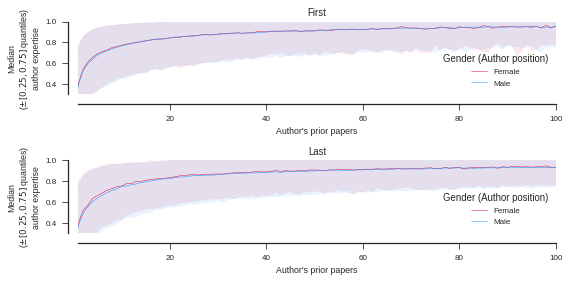

In [61]:
fig, ax = plt.subplots(2,1, figsize=(8,4))
for i, (df_t, title, axi) in enumerate(zip(
        [df_t_first, df_t_last],
        ["First", "Last"],
        ax
    )):
    
    df_t = df_t[~df_t.match_prop.isnull()].groupby(["auth_prev_papers", "gender"]).match_prop.agg([
        pd.Series.median, pd.Series.count,
        get_lower_quantile, get_upper_quantile
    ]).unstack()
    for j, gender in enumerate(genders):
        axi.fill_between(df_t.index,
                 df_t["get_lower_quantile"][gender],
                 df_t["get_upper_quantile"][gender],
                 color=gender_params[gender]["color"],
                 alpha=0.1)

        axi.plot(df_t.index, df_t["median"][gender],
                label=gender_params[gender]["label"],
                color=gender_params[gender]["color"],
                linewidth=linewidth,
                linestyle=linestyle)
    axi.set_ylim([0.3, 1.0])
    axi.set_xlim([1, 100])
    axi.set_title(title)
    axi.set_xlabel("Author's prior papers")
    axi.set_ylabel("Median\n($\pm [0.25, 0.75]$ quantiles)\nauthor expertise")
    axi.legend(title="Gender (Author position)", loc="lower right")
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("Review_Figures/Author_papers_expertise_gender.pdf", bbox_inches="tight")

mean                ci_l                ci_u          
gender                   F         M         F         M         F         M
auth_prev_papers                                                            
0                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1                 0.410855  0.399922  0.410469  0.399567  0.411241  0.400277
2                 0.534227  0.521689  0.533804  0.521308  0.534650  0.522071
3                 0.597923  0.588261  0.597464  0.587861  0.598382  0.588662
4                 0.642608  0.626045  0.642119  0.625621  0.643098  0.626469

mean                ci_l                ci_u          
gender                   F         M         F         M         F         M
auth_prev_papers                                                            
0                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1                 0.408693  0.386917  0.407659  0.386120  0.409726  0.387713
2                 0.517016  0.492043  0.515838  0.491161  0.518195  0.492926
3                 0.567342  0.552091  0.566088  0.551190  0.568596  0.552992
4                 0.621439  0.596012  0.620200  0.595124  0.622678  0.596899

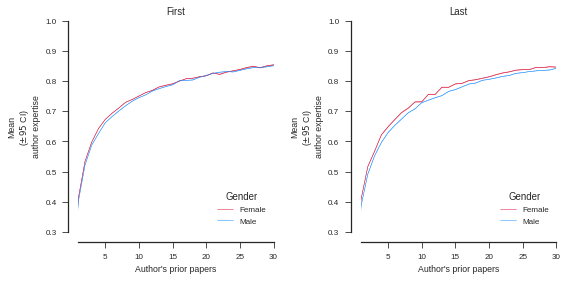

In [62]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
for i, (df_t, title, axi) in enumerate(zip(
        [df_t_first, df_t_last],
        ["First", "Last"],
        ax
    )):
    
    df_t = df_t[~df_t.match_prop.isnull()].groupby(["auth_prev_papers", "gender"]).match_prop.apply(
        mean_confidence_interval
    ).unstack().unstack()
    display(df_t.head())
    for j, gender in enumerate(genders):
        axi.fill_between(df_t.index,
                 df_t["ci_l"][gender],
                 df_t["ci_u"][gender],
                 color=gender_params[gender]["color"],
                 alpha=0.5)

        axi.plot(df_t.index, df_t["mean"][gender],
                label=gender_params[gender]["label"],
                color=gender_params[gender]["color"],
                linewidth=linewidth,
                linestyle=linestyle)
    axi.set_ylim([0.3, 1.0])
    axi.set_xlim([1, 30])
    axi.set_title(title)
    axi.set_xlabel("Author's prior papers")
    axi.set_ylabel("Mean\n($\pm 95%$ CI)\nauthor expertise")
    axi.legend(title="Gender", loc="lower right")
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("Review_Figures/Author_papers_expertise_gender.pdf", bbox_inches="tight")

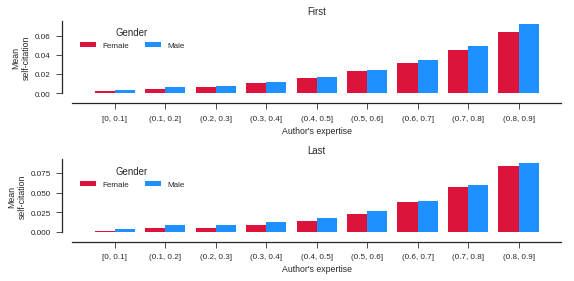

In [63]:
fig, ax = plt.subplots(2,1, figsize=(8,4))
for i, (df_t, title, axi) in enumerate(zip(
        [df_t_first, df_t_last],
        ["First", "Last"],
        ax
    )):
    
    df_t = df_t[~df_t.match_prop.isnull()].assign(
        expertise=lambda x: pd.cut(x["match_prop"],
                                   bins=np.arange(0,1,0.1),
                                   include_lowest=True,
                                   right=True
                                  )
    ).groupby(["expertise", "gender"]).is_self_cite.agg([
        pd.Series.mean, pd.Series.count,
    ]).unstack()
    width=0.4
    for j, gender in enumerate(genders):
        axi.bar(np.arange(df_t.index.shape[0]) + j*width, df_t["mean"][gender],
                label=gender_params[gender]["label"],
                color=gender_params[gender]["color"],
                width=width
               )
    #axi.set_ylim([0.3, 1.0])
    #axi.set_xlim([1, 100])
    axi.set_xticks(np.arange(df_t.index.shape[0]) + width / 2)
    axi.set_xticklabels(df_t.index.values)
    axi.set_title(title)
    axi.set_xlabel("Author's expertise")
    axi.set_ylabel("Mean\nself-citation")
    axi.legend(title="Gender", loc="upper left", ncol=2)
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("Review_Figures/Self_citation_expertise_gender.pdf", bbox_inches="tight")

In [64]:
plt.matplotlib.__version__

'2.0.0'

In [65]:
def model_predictions(df, formula, df_test, verbose=False, model_params=None):
    if model_params is None:
        model_params = dict()
    if verbose:
        print(df.shape, df_test.shape, formula)
    y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
    if verbose:
        print "Created dataframes"
        print "X.shape = %s, y.shape = %s" % (X.shape, y.shape)
    model = Logit(y,X).fit(disp=verbose,
                           **model_params
                           #method='lbfgs', maxiter=50
                          )
    if verbose:
        display(model.summary2())
    _, X_test = patsy.dmatrices(formula, data=df_test, return_type="dataframe")
    if verbose:
        print X_test.shape
    y_test = model.predict(X_test)
    return y_test, model

In [66]:
df_test = pd.DataFrame({
            "auth_prev_papers": np.arange(0,150)
        }).assign(is_self_cite=1)
df_test.head()

,auth_prev_papers,is_self_cite
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [67]:
formula = ("is_self_cite ~ "
               "I(auth_prev_papers == 0)"
               "+ I(auth_prev_papers == 1)"
               "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
              )
y_test, model = model_predictions(
    df_t_first[(df_t_first.gender == "M") 
               & (df_t_first.auth_prev_papers <= 100)],
    formula,
    df_test, verbose=True)

((15801900, 64), (150, 2), 'is_self_cite ~ I(auth_prev_papers == 0)+ I(auth_prev_papers == 1)+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)')
Created dataframes
X.shape = (15801900, 5), y.shape = (15801900, 1)
Optimization terminated successfully.
         Current function value: 0.187466
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
========================================================================================
Model:                     Logit                   Pseudo R-squared:        0.064       
Dependent Variable:        is_self_cite            AIC:                     5924654.1657
Date:                      2017-08-17 11:23        BIC:                     5924727.0439
No. Observations:          15801900                Log-Likelihood:          -2.9623e+06 
Df Model:                  4                       LL-Null:                 -3.1648e+06 
Df Residuals:              15801895                LLR p-value:             0.0000      
Converged:                 1.0000                  Scale:                   1.0000      
No. Iterations:            10.0000                                                      
----------------------------------------------------------------------------------------
                                        Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------
Intercept                              -4.3672   0.0105 -415.6943 0.0000 -4.3878 -4.3466
I(auth_prev_papers == 0)[T.True]       -1.4559   0.0176  -82.6117 0.0000 -1.4905 -1.4214
I(auth_prev_papers == 1)[T.True]       -0.2761   0.0094  -29.5123 0.0000 -0.2944 -0.2577
np.log10(auth_prev_papers + 1)          1.4643   0.0175   83.5181 0.0000  1.4299  1.4986
I(np.log10(auth_prev_papers + 1) ** 2) -0.0989   0.0068  -14.4466 0.0000 -0.1123 -0.0855
========================================================================================

"""

(150, 5)


In [68]:
model.summary2().tables[1].ix["I(auth_prev_papers == 0)[T.True]", ["Coef.", "Std.Err."]]

Coef.      -1.455942
Std.Err.    0.017624
Name: I(auth_prev_papers == 0)[T.True], dtype: float64

In [69]:
paper_filter = 100
df_t_data = df_t_first
df_t_data = df_t_data[(df_t_data.auth_prev_papers <= paper_filter)]
df_t_full = df_t_data.groupby("gender")[["auth_prev_papers", "is_self_cite"]].agg([np.mean, np.std, len])
df_t_full

auth_prev_papers                      is_self_cite                    
                   mean        std       len         mean       std       len
gender                                                                       
-                   NaN        NaN         0          NaN       NaN         0
F             10.205991  15.322557   9172202     0.038016  0.191234   9172202
M             16.654528  21.158397  15801900     0.050600  0.219179  15801900

In [70]:
df_t_full["auth_prev_papers"]

,mean,std,len
gender,,,
-,NaN,NaN,0
F,10.205991,15.322557,9172202
M,16.654528,21.158397,15801900


In [71]:
df_t_full[("auth_prev_papers", "error")] = df_t_full[("auth_prev_papers", "std")] / np.sqrt(df_t_full[("auth_prev_papers", "len")])
df_t_full[("is_self_cite", "error")] = np.sqrt(
    (df_t_full[("is_self_cite", "mean")] * (1-df_t_full[("is_self_cite", "mean")]))/df_t_full[("is_self_cite", "len")])
df_t_full = df_t_full.sort_index(level=0, axis=1)
df_t_full

auth_prev_papers                                is_self_cite            \
                   mean        std       len     error         mean       std   
gender                                                                          
-                   NaN        NaN         0       NaN          NaN       NaN   
F             10.205991  15.322557   9172202  0.005059     0.038016  0.191234   
M             16.654528  21.158397  15801900  0.005323     0.050600  0.219179   

                            
             len     error  
gender                      
-              0       NaN  
F        9172202  0.000063  
M       15801900  0.000055

In [72]:
df_t_full.ix[gender, [("auth_prev_papers", "mean")]].values

array([ 16.65452756])

In [73]:
def get_age_self_cite_data(df_t_data):
    df_t = df_t_data.groupby(
        ["auth_prev_papers", "gender"]).is_self_cite.agg([np.mean, len]).unstack()
    df_t_full = df_t_data.assign(
        auth_prev_papers=np.log10(df_t_data["auth_prev_papers"] + 1).copy()
    ).groupby("gender")[["auth_prev_papers", "is_self_cite"]].agg([np.mean, np.std, len])
    df_t_full[("auth_prev_papers", "error")] = df_t_full[("auth_prev_papers", "std")] / np.sqrt(df_t_full[("auth_prev_papers", "len")])
    df_t_full[("is_self_cite", "error")] = np.sqrt(
        ((df_t_full[("is_self_cite", "mean")]
          * (1-df_t_full[("is_self_cite", "mean")])
         )/df_t_full[("is_self_cite", "len")]))
    df_t_full[("auth_prev_papers", "l_error")] = 10**(
        df_t_full[("is_self_cite", "mean")] - df_t_full[("is_self_cite", "error")]) - 1
    df_t_full[("auth_prev_papers", "u_error")] = 10**(
        df_t_full[("is_self_cite", "mean")] + df_t_full[("is_self_cite", "error")]) - 1
    df_t_full = df_t_full.sort_index(level=0, axis=1)
    
    error = np.sqrt(df_t["mean"].multiply(1 - df_t["mean"]).divide(df_t["len"]))
    return df_t, df_t_full, error


def plot_age_vs_self_cite(axi, df_t_data, df_t, df_t_full, error, gender,
                          gender_params, plot_params, model_params,
                          formula, df_test, error_plot=True,
                          mean_line=False, verbose=False):
    """
    TODO: Add beta of Male Female indicator to the plot. 
    """
    error_params = gender_params[gender]
    if error_plot:
        axi.errorbar(df_t.index.values, df_t["mean"][gender].values,
                     yerr=error[gender].values,
                     color=gender_params[gender]["color"],
                     #label=gender_params[gender]["label"],
                     marker=gender_params[gender]["marker"],
                     **plot_params
                    )
    else:
        axi.plot(df_t.index.values, df_t["mean"][gender].values,
                     color=gender_params[gender]["color"],
                     #label=gender_params[gender]["label"],
                     marker=gender_params[gender]["marker"],
                     **dict([(k,v)
                         for k,v in plot_params.items()
                         if k not in set(["capsize", "elinewidth"])
                     ])
                    )

    x_mean = 10**(df_t_full.ix[gender, [("auth_prev_papers", "mean")]].values)-1
    y_mean = df_t_full.ix[gender, [("is_self_cite", "mean")]].values
    y_mean_err = df_t_full.ix[gender, [("is_self_cite", "error")]].values
    if mean_line:
        axi.axhline(
            y=y_mean[0],
            color=gender_params[gender]["color"],
            label="{} ({:.2f}% self-citations)".format(
                gender_params[gender]["label"], y_mean[0]*100),
            linestyle="--",
            lw=linewidth+1
        )
    else:
        axi.errorbar(
            x_mean, y_mean,
            #xerr=[df_t_full[("auth_prev_papers", "l_error")].values,
            #      df_t_full[("auth_prev_papers", "u_error")].values],
            yerr=y_mean_err,
            color=gender_params[gender]["color"],
            marker=gender_params[gender]["marker"],
            label="{}(x={:.2f},y={:.2f})".format(
                gender_params[gender]["label"], x_mean[0], y_mean[0]*100),
            ms=10,
        )

    print "Fitting model for %s" % gender
    model = None
    try:
        y_test, model = model_predictions(
                df_t_data,
                formula, df_test, verbose=verbose, model_params=model_params)
        axi.plot(df_test["auth_prev_papers"], y_test,
                 color=gender_params[gender]["color"],
                 linestyle="-",
                 linewidth=linewidth
                )
    except:
        print("Modeling failed.")
        print(df_t_data[df_t_data.auth_prev_papers < 2].auth_prev_papers.value_counts())
        import traceback
        traceback.print_exc()
    return axi, model

def plot_age_dist(axi_dist, df_t, gender, gender_params, cdf=False):
    # Plot distribution
    y = (df_t["len"][gender] * 1./ df_t["len"][gender].sum())
    if cdf:
        y = y.cumsum()
    axi_dist.plot(df_t.index, y,
                  color=gender_params[gender]["color"],
                  label=gender_params[gender]["label"],
                  marker=gender_params[gender]["marker"],
                  linestyle="-",
                  alpha=0.5,
                  markersize=markersize
    )
    return axi_dist
    
    

In [74]:
plot_params

{'alpha': 0.6,
 'capsize': 0.5,
 'elinewidth': 0.01,
 'linestyle': 'none',
 'markersize': 3}

Fitting model for F
Fitting model for M
Fitting model for F
Fitting model for M


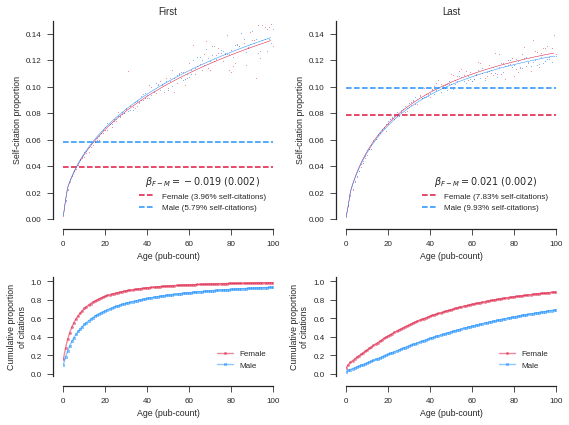

In [75]:
formula = ("is_self_cite ~ "
               "I(auth_prev_papers == 0)"
               "+ I(auth_prev_papers == 1)"
               "+ C(gender, levels=['M', 'F'])"
               "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
              )

fig, ax = plt.subplots(
    nrows=2, ncols=2,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios': [2, 1]},
    figsize=(8,6))
paper_filter = 100

for i, (df_t_data, title) in enumerate(zip(
        [df_t_first, df_t_last],
        ["First", "Last"],
    )):
    axi, axi_dist = ax[:, i].flatten()
    #df_t_data = df_t_data[(df_t_data.auth_prev_papers <= paper_filter)]
        
    df_t, df_t_full, error = get_age_self_cite_data(df_t_data)
    for j, gender in enumerate(genders):
        df_test = pd.DataFrame({
                    "auth_prev_papers": np.arange(0,min([paper_filter, 150]))
                }).assign(is_self_cite=1, gender=gender)
        model_params = dict()
        axi, model = plot_age_vs_self_cite(axi,
                                    df_t_data, #[df_t_data.gender == gender],
                                    df_t, df_t_full, error, gender,
                                    gender_params, {
                                        k: (1 if k == "markersize" else v)
                                        for k,v in plot_params.items()
                                    }, model_params,
                                    formula, df_test, mean_line=True, verbose=False)
        axi_dist = plot_age_dist(axi_dist, df_t, gender, gender_params, cdf=True)
        legend_title = ""
        if model:
            model_stats = model.summary2().tables[1].ix[
                "C(gender, levels=['M', 'F'])[T.F]",
                ["Coef.", "Std.Err."]].values
            legend_title = "$\\beta_{F-M}=%.3f\ (%.3f)$" % (model_stats[0], model_stats[1])
    axi.set_ylim([0, 0.15])
    axi.set_xlim([0, 100])
    axi.set_title(title)
    axi.set_xlabel("Age (pub-count)")
    axi.set_ylabel("Self-citation proportion")
    axi.legend(loc='lower right', title=legend_title)

    axi_dist.legend(loc='lower right')
    axi_dist.set_xlabel("Age (pub-count)")
    axi_dist.set_ylabel("Cumulative proportion\nof citations")
    
#ax.legend(title="Gender (Author position)", loc="lower right")
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("Review_Figures/Author_papers_self_cite_gender.pdf", bbox_inches="tight")

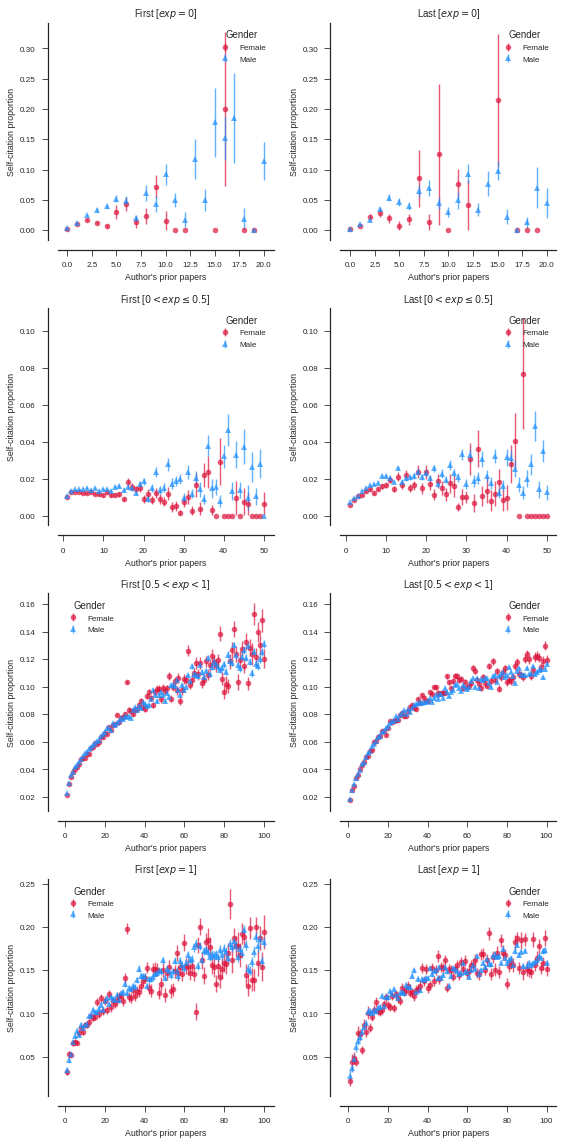

In [76]:
fig, ax = plt.subplots(4,2, sharey="row", figsize=(8,16))

filters = [
    (lambda x: x == 0, "$%s = 0$", 20),
    (lambda x: (x > 0) & (x <= 0.5), "$0 < %s \leq 0.5$", 50,),
    (lambda x: (x > 0.5) & (x < 1), "$0.5 < %s < 1$", 100),
    (lambda x: x == 1, "$%s = 1$", 100),
          ]
for i, (idx_filter, filter_title, paper_filter) in enumerate(filters):
    for j, (df_t, title, axi) in enumerate(zip(
            [df_t_first, df_t_last],
            ["First", "Last"],
            ax[i]
        )):
        df_t = df_t[idx_filter(df_t.match_prop) & (df_t.auth_prev_papers <= paper_filter)].groupby(
            ["auth_prev_papers", "gender"]).is_self_cite.agg([np.mean, len]).unstack()
        error = np.sqrt(df_t["mean"].multiply(1 - df_t["mean"]).divide(df_t["len"]))
        axi.errorbar(df_t.index, df_t["mean"]["F"], yerr=error["F"],
                 label="Female", color="crimson", linestyle="none", marker="o", alpha=0.7)
        axi.errorbar(df_t.index, df_t["mean"]["M"], yerr=error["M"],
                     label="Male", color="dodgerblue", linestyle="none", marker="^", alpha=0.7)
        axi.set_title("%s [%s]" % (title, filter_title % "exp"))
        axi.set_xlabel("Author's prior papers")
        axi.set_ylabel("Self-citation proportion")
        axi.legend(loc='best', title="Gender")
#ax.legend(title="Gender (Author position)", loc="lower right")
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("Review_Figures/Author_papers_self_cite_gender_exp.pdf", bbox_inches="tight")

## Load Journal names

In [77]:
%%time
df_journals = pd.read_csv("data/FullArticlesData.txt", sep="\t", usecols=["PMID", "journal"])
df_journals.head()

CPU times: user 1min 26s, sys: 6.56 s, total: 1min 32s
Wall time: 1min 32s


In [78]:
df_journals.head()

,PMID,journal
0,26151966,J Hum Lact
1,26151965,J Hum Lact
2,26151955,EuroIntervention
3,26151954,EuroIntervention
4,26151953,EuroIntervention


In [79]:
df_journals.journal.value_counts().head(30)

J Biol Chem                   171068
Science                       167415
PLoS One                      133591
Lancet                        129945
Proc Natl Acad Sci U S A      121705
Nature                        104418
Br Med J                       97226
Biochim Biophys Acta           96039
Biochem Biophys Res Commun     78341
Phys Rev Lett                  76322
N Engl J Med                   72020
JAMA                           66849
BMJ                            65858
Biochemistry                   62430
J Immunol                      62245
Brain Res                      56834
Am J Physiol                   54726
Biochem J                      54355
J Bacteriol                    51716
J Am Chem Soc                  50057
Cancer Res                     48966
Ann N Y Acad Sci               47684
J Urol                         47368
Phys Rev B Condens Matter      46890
FEBS Lett                      46770
Appl Opt                       43386
Blood                          43160
J

## Journal categories

* MEDICINE - NEMJ, JAMA, LANCET
* BIOLOGY - CELL, Journal of Bio Chem
* Bioinformatics - PLoS Com Bio, BMC BioInfo
* EPIDEMIOLOGY - MMWR. Morbidity and Mortality Weekly Report, Emerging Infectious Diseases, International Journal of Epidemiology
* DENTISTRY - Journal of Endodontics, Journal of Clinical Periodontology, Journal of Dental Research
* GENERIC - Proc Natl Acad Sci U S A, Nature, Science, PLoS One

In [80]:
JOURNAL_NAMES  = dict(
    GENERIC=set(['Proc Natl Acad Sci U S A', 'Nature', 'Science',
                 'Ann N Y Acad Sci',]), # General Science
    MEDICINE = set(['JAMA', 'Lancet', 'N Engl J Med',
                    'BMJ', 'Cancer Res', 'Clin Cancer Res', 'J Clin Oncol',
                    'J Am Coll Cardiol', 'Gut', 'Circulation', 'Blood',
                    'J Immunol', 'Brain Res', #'Am J Physiol',
                    'J Urol', 
                    #'Med J Aust', 'Ugeskr Laeger'
                   ]), # General Medicine
    BIOLOGY = set(['J Biol Chem', 'Cell',  'Adv Exp Med Biol',
                   'Mol Cell', 'Biochim Biophys Acta', 'Biochemistry',
                   'Biochem J', 'FEBS Lett', 'J Bacteriol', 'J Virol',
                   'Bioinformatics', 'Nucleic Acids Res',
                  ]), # Biology
)

JOURNAL_NAMES

{'BIOLOGY': {'Adv Exp Med Biol',
  'Biochem J',
  'Biochemistry',
  'Biochim Biophys Acta',
  'Bioinformatics',
  'Cell',
  'FEBS Lett',
  'J Bacteriol',
  'J Biol Chem',
  'J Virol',
  'Mol Cell',
  'Nucleic Acids Res'},
 'GENERIC': {'Ann N Y Acad Sci',
  'Nature',
  'Proc Natl Acad Sci U S A',
  'Science'},
 'MEDICINE': {'BMJ',
  'Blood',
  'Brain Res',
  'Cancer Res',
  'Circulation',
  'Clin Cancer Res',
  'Gut',
  'J Am Coll Cardiol',
  'J Clin Oncol',
  'J Immunol',
  'J Urol',
  'JAMA',
  'Lancet',
  'N Engl J Med'}}

In [81]:
df_journals[df_journals.journal.isin(JOURNAL_NAMES["MEDICINE"])].journal.value_counts()

Lancet               129945
N Engl J Med          72020
JAMA                  66849
BMJ                   65858
J Immunol             62245
Brain Res             56834
Cancer Res            48966
J Urol                47368
Blood                 43160
Circulation           40094
J Am Coll Cardiol     21580
J Clin Oncol          21075
Gut                   15952
Clin Cancer Res       14845
Name: journal, dtype: int64

In [82]:
pd.concat([df_journals[df_journals.journal.isin(v)
                      ][["PMID", "journal"]].assign(JOURNAL_TYPE=k).reset_index(drop=True)
          for k,v in JOURNAL_NAMES.items()]).head()

,PMID,journal,JOURNAL_TYPE
0,26151898,Brain Res,MEDICINE
1,26151676,J Urol,MEDICINE
2,26151285,JAMA,MEDICINE
3,26151284,JAMA,MEDICINE
4,26151282,JAMA,MEDICINE


In [83]:
df_test.assign(gender=gender).head()

,auth_prev_papers,gender,is_self_cite
0,0,M,1
1,1,M,1
2,2,M,1
3,3,M,1
4,4,M,1


In [84]:
def get_journal_data(df_t_data, journal_name):
    journal_ids = set(df_journals.ix[df_journals.journal == journal_name, "PMID"].values)
    print(journal_name, len(journal_ids))
    df_t_data = df_t_data[(df_t_data.source_id.isin(journal_ids))]
    return df_t_data
    

def plot_journal_data(formula, selected_journals, filename,
                      paper_filter = 10000, min_citations=20000, verbose=False):
    nrows=len(selected_journals)
    fig = plt.figure(figsize=(8,4*nrows))
    grid_size=(nrows,2)
    journal_group_stats = []
    for k, journal_name in enumerate(selected_journals):
        journal_ids = set(df_journals.ix[df_journals.journal == journal_name, "PMID"].values)
        print(journal_name, len(journal_ids))
        for i, (df_t_data, title) in enumerate(zip(
                [df_t_first, df_t_last],
                ["First", "Last"],
            )):
            axi = plt.subplot2grid(grid_size, (k, i))
            df_t_data = df_t_data[
                (df_t_data.auth_prev_papers <= paper_filter)
                & (df_t_data.source_id.isin(journal_ids))
            ]
            df_t, df_t_full, error = get_age_self_cite_data(df_t_data)
            print(title, df_t_data.shape)
            if df_t_data.shape[0] < min_citations:
                    continue
            legend_title=""
            model_stats = [np.nan, np.nan, np.nan]
            for j, gender in enumerate(genders):
                df_test = pd.DataFrame({
                    "auth_prev_papers": np.arange(0,min([paper_filter, 150]))
                }).assign(is_self_cite=1, gender=gender)
                model_params = dict(method='lbfgs', maxiter=50)
                axi, model = plot_age_vs_self_cite(axi, df_t_data, df_t, df_t_full,
                                            error, gender, gender_params, plot_params, model_params,
                                            formula, df_test, mean_line=True, error_plot=False)
                if model:
                    model_stats = model.summary2().tables[1].ix[
                        "C(gender, levels=['M', 'F'])[T.F]",
                        ["Coef.", "Std.Err.", "P>|z|"]].values.tolist()
                    legend_title = "$\\beta_{F-M}=%.3f\\ (%.3f)$" % (model_stats[0], model_stats[1])
            journal_group_stats.append(
                [journal_name, title, df_t_data.shape[0]]+model_stats)
            axi.set_ylim([0, 0.24])
            xlim_max = 150
            if title == "First":
                xlim_max = 50
            axi.set_xlim([0, min([paper_filter, xlim_max])])
            axi.set_title("{0} [n={1:,}]\n({2})".format(title, df_t_data.shape[0], journal_name))
            axi.set_xlabel("Age (pub count)")
            axi.set_ylabel("Self-citation proportion")
            legend = axi.legend(loc='upper left', title=legend_title, ncol=1)
            legend.get_frame().set_facecolor('#FFFFFF')
        #ax.legend(title="Gender (Author position)", loc="lower right")
    sns.despine(offset=10)
    fig.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    return fig, journal_group_stats

In [85]:
def get_proportion(journal_name, paper_filter=100, verbose=False):
    journal_ids = set(df_journals.ix[df_journals.journal == journal_name, "PMID"].values)
    if verbose:
        print(journal_name, len(journal_ids))
    print("Paper cutoff: {}".format(paper_filter))
    for i, (df_t_data, title) in enumerate(zip(
            [df_t_first, df_t_last],
            ["First", "Last"],
        )):
        df_t = df_t_data[
            (df_t_data.source_id.isin(journal_ids))
        ]
        print(df_t.shape)
        display(df_t.gender.value_counts())
        total_papers = df_t.shape[0]
        df_t = df_t[(df_t.auth_prev_papers <= paper_filter)]
        print("{}\tProportion: {:.2f}%".format(title, df_t.shape[0]* 100./total_papers))       

In [86]:
get_proportion('Proc Natl Acad Sci U S A', paper_filter=30)

Paper cutoff: 30
(298356, 64)


M    201791
F     96565
-         0
Name: gender, dtype: int64

First	Proportion: 89.78%
(334968, 64)


M    284467
F     50501
-         0
Name: gender, dtype: int64

Last	Proportion: 26.02%


('Cell', 17515)
('First', (32399, 64))
Fitting model for F
Fitting model for M
('Last', (37042, 64))
Fitting model for F
Fitting model for M


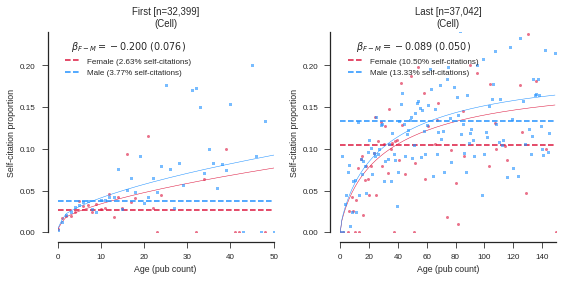

In [87]:
journal_formula = ("is_self_cite ~ "
               "I(auth_prev_papers == 0)"
                "+ I(auth_prev_papers == 1)"
                "+ C(gender, levels=['M', 'F'])"
               "+ np.log10(auth_prev_papers + 1)"
                "+ I(np.log10(auth_prev_papers + 1)**2)"
              )
selected_journals = {'Cell',}
filename = "Review_Figures/Author_papers_self_cite_gender_journals.pdf"
fig, journal_group_stats = plot_journal_data(journal_formula, selected_journals, filename)

In [88]:
pd.DataFrame(journal_group_stats, columns=[
    "Journal", "Author Position", "citations",
    "beta", "stderr", "p-value"
]).pivot(index="Journal", columns="Author Position").reorder_levels([1,0], axis=1).sortlevel(0, axis=1)

Author Position     First                                    Last           \
                citations      beta    stderr   p-value citations     beta   
Journal                                                                      
Cell                32399 -0.200469  0.075531  0.007951     37042 -0.08922   

Author Position                     
                  stderr   p-value  
Journal                             
Cell             0.04975  0.072915

# Plot per journal category

MEDICINE
('Cancer Res', 48966)
('First', (131329, 64))
Fitting model for F
Fitting model for M
('Last', (149313, 64))
Fitting model for F
Fitting model for M
('Circulation', 40094)
('First', (92220, 64))
Fitting model for F
Fitting model for M
('Last', (98741, 64))
Fitting model for F
Fitting model for M
('N Engl J Med', 72020)
('First', (30970, 64))
Fitting model for F
Fitting model for M
('Last', (31971, 64))
Fitting model for F
Fitting model for M
('BMJ', 65858)
('First', (23987, 64))
Fitting model for F
Fitting model for M
('Last', (24438, 64))
Fitting model for F
Fitting model for M
('J Am Coll Cardiol', 21580)
('First', (50523, 64))
Fitting model for F
Fitting model for M
('Last', (52579, 64))
Fitting model for F
Fitting model for M
('J Clin Oncol', 21075)
('First', (61722, 64))
Fitting model for F
Fitting model for M
('Last', (62049, 64))
Fitting model for F
Fitting model for M
('J Immunol', 62245)
('First', (208354, 64))
Fitting model for F
Fitting model for M
('Last', (228129,

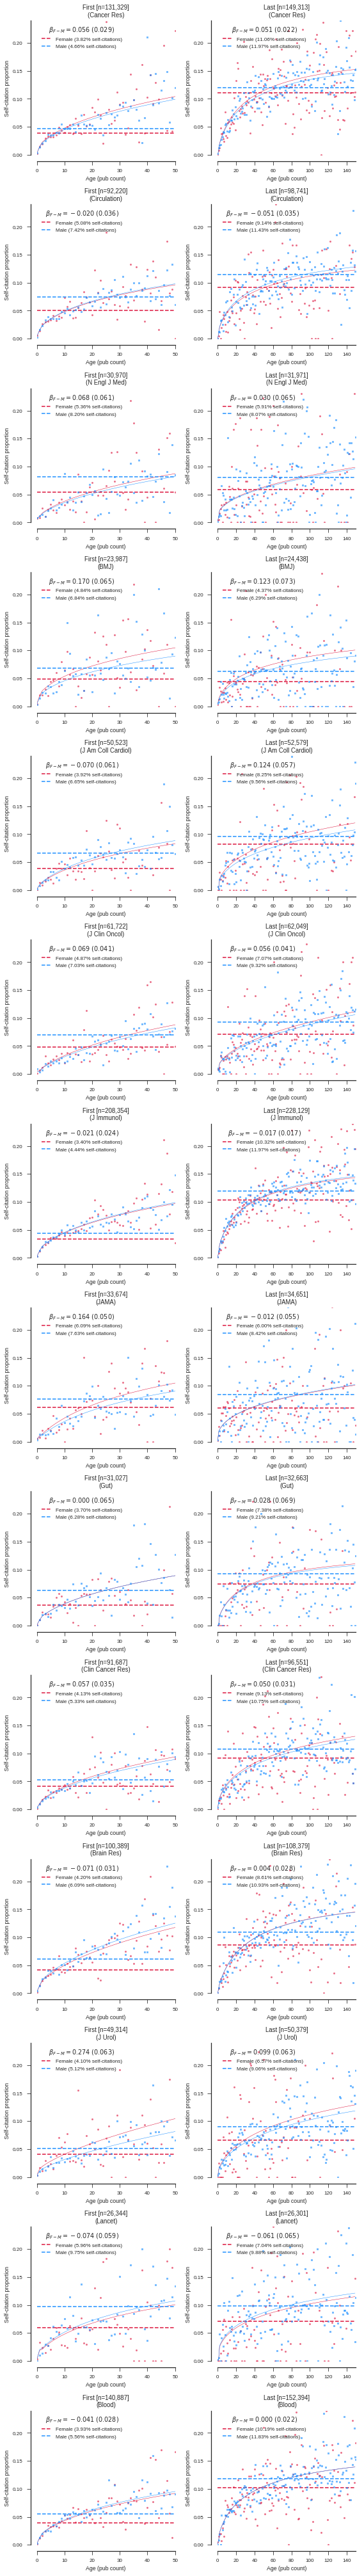

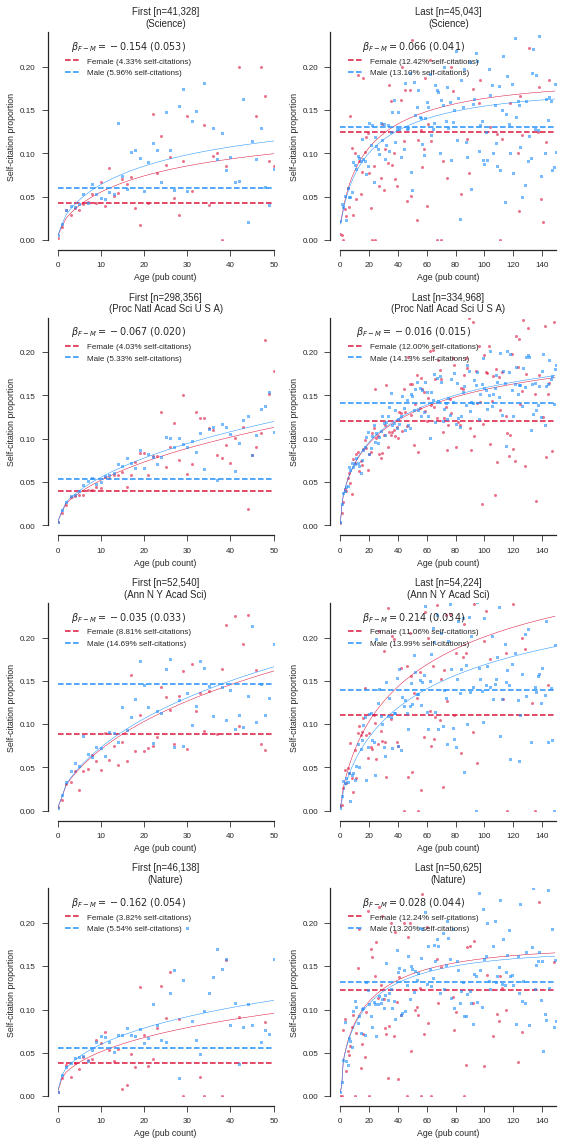

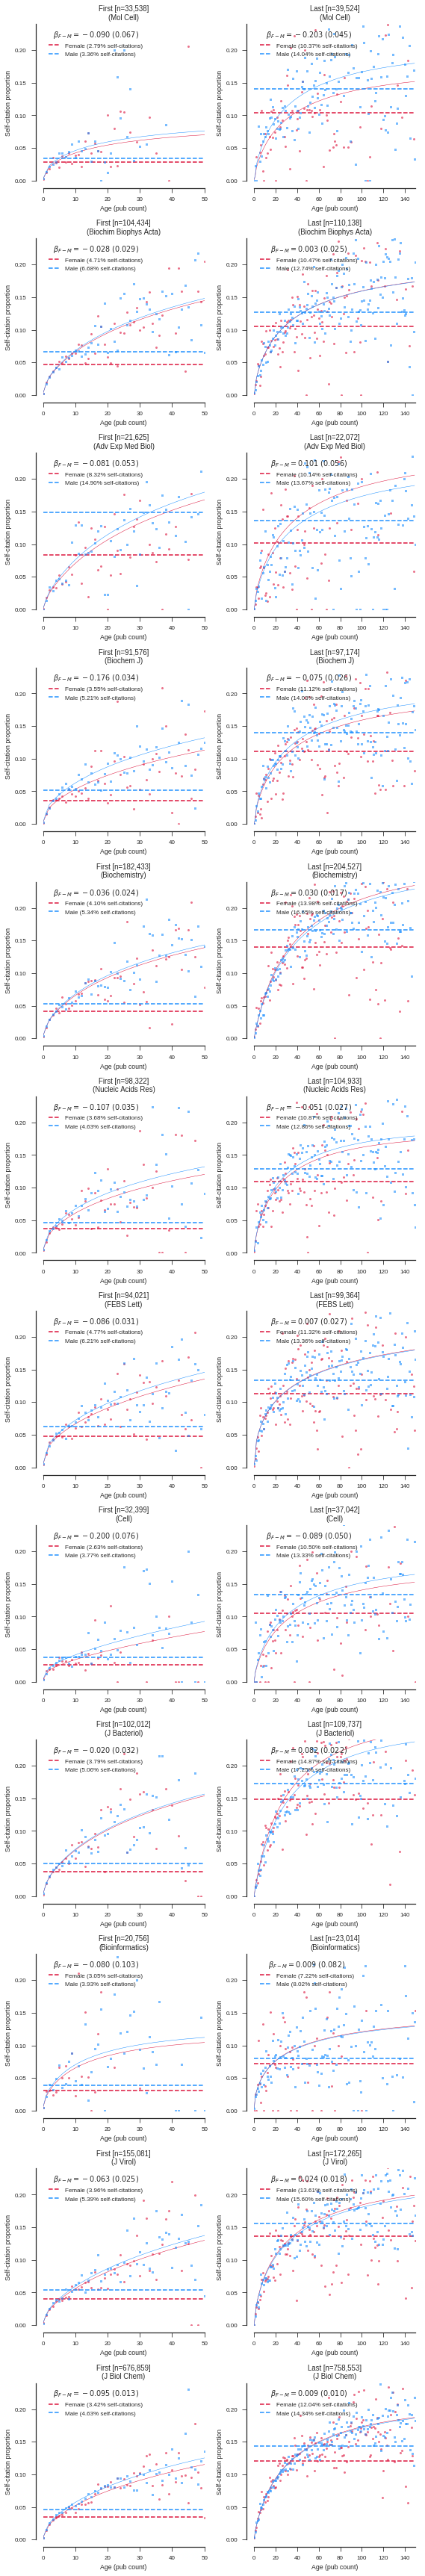

In [89]:
journal_formula = ("is_self_cite ~ "
               "I(auth_prev_papers == 0)"
                "+ I(auth_prev_papers == 1)"
                " + C(gender, levels=['M', 'F'])"
               "+ np.log10(auth_prev_papers + 1)"
                "+ I(np.log10(auth_prev_papers + 1)**2)"
              )
df_journal_stats = {}
for journal_cat, selected_journals in JOURNAL_NAMES.items():
    print(journal_cat)
    filename = "Review_Figures/Author_papers_self_cite_gender_journals_{}.pdf".format(journal_cat)
    fig, journal_group_stats = plot_journal_data(journal_formula, selected_journals, filename)
    df_journal_stats[journal_cat] = journal_group_stats

In [90]:
journal_table_cols = [
    "Journal", "Author Position", "citations",
    "beta", "stderr", "p-value"
]
JOURNAL_CAT_NAMINGS={
    "GENERIC": "Science",
    "MEDICINE": "Medicine",
    "BIOLOGY": "Biology",
}
df_journal_stats_all = pd.concat(
    {
        JOURNAL_CAT_NAMINGS[k]: pd.DataFrame(journal_group_stats,
                        columns=journal_table_cols).pivot(
            index="Journal", columns="Author Position"
        ).reorder_levels([1,0], axis=1).sortlevel(0, axis=1).sort_values(
            ("First", "citations"), ascending=False)
        
        for k,journal_group_stats in df_journal_stats.items()
    }
)
with pd.option_context("display.precision",3, 'display.float_format', lambda x: '%.3f' % x):
    display(df_journal_stats_all)

Author Position                       First                            Last  \
                                  citations   beta stderr p-value citations   
         Journal                                                              
Biology  J Biol Chem                 676859 -0.095  0.013   0.000    758553   
         Biochemistry                182433 -0.036  0.024   0.143    204527   
         J Virol                     155081 -0.063  0.025   0.013    172265   
         Biochim Biophys Acta        104434 -0.028  0.029   0.344    110138   
         J Bacteriol                 102012 -0.020  0.032   0.535    109737   
         Nucleic Acids Res            98322 -0.107  0.035   0.002    104933   
         FEBS Lett                    94021 -0.086  0.031   0.005     99364   
         Biochem J                    91576 -0.176  0.034   0.000     97174   
         Mol Cell                     33538 -0.090  0.067   0.182     39524   
         Cell                         32399 -0.200  0.076   0.008     37042   
         Adv Exp Med Biol             21625 -0.081  0.053   0.124     22072   
         Bioinformatics               20756 -0.080  0.103   0.437     23014   
Medicine J Immunol                   208354 -0.021  0.024   0.389    228129   
         Blood                       140887 -0.041  0.028   0.140    152394   
         Cancer Res                  131329  0.056  0.029   0.057    149313   
         Brain Res                   100389 -0.071  0.031   0.025    108379   
         Circulation                  92220 -0.020  0.036   0.575     98741   
         Clin Cancer Res              91687  0.057  0.035   0.101     96551   
         J Clin Oncol                 61722  0.069  0.041   0.093     62049   
         J Am Coll Cardiol            50523 -0.070  0.061   0.248     52579   
         J Urol                       49314  0.274  0.063   0.000     50379   
         JAMA                         33674  0.164  0.050   0.001     34651   
         Gut                          31027  0.000  0.065   1.000     32663   
         N Engl J Med                 30970  0.068  0.061   0.270     31971   
         Lancet                       26344 -0.074  0.059   0.209     26301   
         BMJ                          23987  0.170  0.065   0.009     24438   
Science  Proc Natl Acad Sci U S A    298356 -0.067  0.020   0.001    334968   
         Ann N Y Acad Sci             52540 -0.035  0.033   0.288     54224   
         Nature                       46138 -0.162  0.054   0.003     50625   
         Science                      41328 -0.154  0.053   0.004     45043   

Author Position                                          
                                    beta stderr p-value  
         Journal                                         
Biology  J Biol Chem               0.009  0.010   0.348  
         Biochemistry              0.030  0.017   0.084  
         J Virol                   0.024  0.018   0.185  
         Biochim Biophys Acta      0.003  0.025   0.915  
         J Bacteriol               0.082  0.022   0.000  
         Nucleic Acids Res        -0.051  0.027   0.061  
         FEBS Lett                 0.007  0.027   0.805  
         Biochem J                -0.075  0.026   0.004  
         Mol Cell                 -0.203  0.045   0.000  
         Cell                     -0.089  0.050   0.073  
         Adv Exp Med Biol          0.101  0.056   0.070  
         Bioinformatics            0.009  0.082   0.912  
Medicine J Immunol                -0.017  0.017   0.324  
         Blood                     0.000  0.022   0.984  
         Cancer Res                0.051  0.022   0.018  
         Brain Res                 0.004  0.028   0.882  
         Circulation              -0.051  0.035   0.143  
         Clin Cancer Res           0.050  0.031   0.113  
         J Clin Oncol              0.056  0.041   0.176  
         J Am Coll Cardiol         0.124  0.057   0.030  
         J Urol                    0.099  0.063   0.113  


In [91]:
with pd.option_context("display.precision",3, 'display.float_format', lambda x: '%.3f' % x):
    print(df_journal_stats_all.to_latex())

\begin{tabular}{llrrrrrrrr}
\toprule
        &                  &     First &        &        &         &      Last &        &        &         \\
        &                  & citations &   beta & stderr & p-value & citations &   beta & stderr & p-value \\
{} & Journal &           &        &        &         &           &        &        &         \\
\midrule
Biology & J Biol Chem &    676859 & -0.095 &  0.013 &   0.000 &    758553 &  0.009 &  0.010 &   0.348 \\
        & Biochemistry &    182433 & -0.036 &  0.024 &   0.143 &    204527 &  0.030 &  0.017 &   0.084 \\
        & J Virol &    155081 & -0.063 &  0.025 &   0.013 &    172265 &  0.024 &  0.018 &   0.185 \\
        & Biochim Biophys Acta &    104434 & -0.028 &  0.029 &   0.344 &    110138 &  0.003 &  0.025 &   0.915 \\
        & J Bacteriol &    102012 & -0.020 &  0.032 &   0.535 &    109737 &  0.082 &  0.022 &   0.000 \\
        & Nucleic Acids Res &     98322 & -0.107 &  0.035 &   0.002 &    104933 & -0.051 &  0.027 &   0.061

In [92]:
df_journal_stats_all.shape

(30, 8)

# Plot full models for journals

In [93]:
df_t_first.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

In [94]:
journal_model_formula = ("is_self_cite ~ "
            "I(auth_prev_papers == 0)"
           "+ I(auth_prev_papers == 1)"
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=['M', 'F'])"
           #"+ C(source_country, levels=TOP_15_COUNTRIES)"
           #"+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           #"+ I(source_ncites == 1)"
           "+ np.log10(source_ncites)"
           "+ I(np.log10(source_ncites)**2) "#"+ I(np.log10(source_ncites)**3)"
           #"+ I(source_n_authors > 20)"
           #              " + np.log10(np.clip(source_n_authors, 0, 20))"
           #"+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           #"+ np.log10(source_n_mesh_ex + 1) + "#"I(source_n_mesh_ex == 0)" 
           #"+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0)"
                         " + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) "
                         "+ np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           #"+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           #"+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           #"+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           #"+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )

In [95]:
journal_full_model_stats = dict()
for journal_cat, selected_journals in JOURNAL_NAMES.items():
    journal_group_full_model_stats = []
    for journal_name in selected_journals:
        for i, (df_t_data, title) in enumerate(zip(
                        [df_t_first, df_t_last],
                        ["First", "Last"],
                    )):
            print(title)
            model_stats = [np.nan, np.nan, np.nan]
            df_t_data = get_journal_data(df_t_data, journal_name).copy()
            #prepare_data(df_t_data)
            try:
                y_test, model = model_predictions(
                    df_t_data, journal_model_formula,
                    df_t_data.iloc[:3], verbose=False,
                    model_params=dict(method='lbfgs', maxiter=100))
                model_stats = model.summary2().tables[1].ix[
                        "C(gender, levels=['M', 'F'])[T.F]",
                        ["Coef.", "Std.Err.", "P>|z|"]].values.tolist()
            except:
                print("Failed to fit")
            journal_group_full_model_stats.append(
                [journal_name, title, df_t_data.shape[0]]+model_stats
            )
    journal_full_model_stats[journal_cat] = journal_group_full_model_stats

First
('Cancer Res', 48966)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Cancer Res', 48966)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Circulation', 40094)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Circulation', 40094)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('N Engl J Med', 72020)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('N Engl J Med', 72020)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('BMJ', 65858)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('BMJ', 65858)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('J Am Coll Cardiol', 21580)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('J Am Coll Cardiol', 21580)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('J Clin Oncol', 21075)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('J Clin Oncol', 21075)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('J Immunol', 62245)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('J Immunol', 62245)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('JAMA', 66849)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('JAMA', 66849)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Gut', 15952)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Gut', 15952)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Clin Cancer Res', 14845)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Clin Cancer Res', 14845)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Brain Res', 56834)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Brain Res', 56834)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('J Urol', 47368)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('J Urol', 47368)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Lancet', 129945)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Lancet', 129945)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Blood', 43160)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Blood', 43160)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Science', 167415)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Science', 167415)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Proc Natl Acad Sci U S A', 121705)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Proc Natl Acad Sci U S A', 121705)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Ann N Y Acad Sci', 47684)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Ann N Y Acad Sci', 47684)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Nature', 104418)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Nature', 104418)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Mol Cell', 5804)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Mol Cell', 5804)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Biochim Biophys Acta', 96039)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Biochim Biophys Acta', 96039)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Adv Exp Med Biol', 31938)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Adv Exp Med Biol', 31938)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Biochem J', 54355)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Biochem J', 54355)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Biochemistry', 62430)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Biochemistry', 62430)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Nucleic Acids Res', 39570)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Nucleic Acids Res', 39570)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('FEBS Lett', 46770)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('FEBS Lett', 46770)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Cell', 17515)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Cell', 17515)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('J Bacteriol', 51716)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('J Bacteriol', 51716)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('Bioinformatics', 10026)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('Bioinformatics', 10026)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('J Virol', 42269)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Last
('J Virol', 42269)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


First
('J Biol Chem', 171068)
Last
('J Biol Chem', 171068)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [96]:
journal_table_cols = [
    "Journal", "Author Position", "citations",
    "beta", "stderr", "p-value"
]
JOURNAL_CAT_NAMINGS={
    "GENERIC": "Science",
    "MEDICINE": "Medicine",
    "BIOLOGY": "Biology",
}

df_journal_full_model_stats = pd.concat(
    {
        JOURNAL_CAT_NAMINGS[k]: pd.DataFrame(journal_group_stats,
                        columns=journal_table_cols).pivot(
            index="Journal", columns="Author Position"
        ).reorder_levels([1,0], axis=1).sortlevel(0, axis=1).sort_values(
            ("First", "citations"), ascending=False)
        
        for k,journal_group_stats in journal_full_model_stats.items()
    }
)
with pd.option_context("display.precision",3, 'display.float_format', lambda x: '%.3f' % x):
    display(df_journal_full_model_stats)

Author Position                       First                            Last  \
                                  citations   beta stderr p-value citations   
         Journal                                                              
Biology  J Biol Chem                 676859 -0.103  0.014   0.000    758553   
         Biochemistry                182433 -0.005  0.026   0.859    204527   
         J Virol                     155081 -0.063  0.027   0.018    172265   
         Biochim Biophys Acta        104434 -0.004  0.031   0.895    110138   
         J Bacteriol                 102012 -0.038  0.034   0.265    109737   
         Nucleic Acids Res            98322 -0.037  0.037   0.315    104933   
         FEBS Lett                    94021 -0.037  0.032   0.248     99364   
         Biochem J                    91576 -0.153  0.036   0.000     97174   
         Mol Cell                     33538 -0.105  0.068   0.124     39524   
         Cell                         32399 -0.151  0.076   0.047     37042   
         Adv Exp Med Biol             21625 -0.101  0.055   0.069     22072   
         Bioinformatics               20756 -0.105  0.109   0.336     23014   
Medicine J Immunol                   208354 -0.028  0.025   0.254    228129   
         Blood                       140887 -0.035  0.028   0.217    152394   
         Cancer Res                  131329  0.050  0.030   0.100    149313   
         Brain Res                   100389 -0.099  0.034   0.003    108379   
         Circulation                  92220  0.053  0.037   0.155     98741   
         Clin Cancer Res              91687  0.066  0.036   0.066     96551   
         J Clin Oncol                 61722  0.078  0.042   0.064     62049   
         J Am Coll Cardiol            50523 -0.068  0.062   0.271     52579   
         J Urol                       49314  0.364  0.066   0.000     50379   
         JAMA                         33674  0.204  0.051   0.000     34651   
         Gut                          31027  0.035  0.067   0.605     32663   
         N Engl J Med                 30970  0.017  0.063   0.780     31971   
         Lancet                       26344 -0.075  0.059   0.207     26301   
         BMJ                          23987  0.057  0.067   0.396     24438   
Science  Proc Natl Acad Sci U S A    298356 -0.008  0.020   0.688    334968   
         Ann N Y Acad Sci             52540  0.003  0.034   0.929     54224   
         Nature                       46138 -0.110  0.055   0.047     50625   
         Science                      41328 -0.122  0.054   0.025     45043   

Author Position                                          
                                    beta stderr p-value  
         Journal                                         
Biology  J Biol Chem               0.015  0.010   0.122  
         Biochemistry              0.024  0.018   0.186  
         J Virol                   0.005  0.019   0.781  
         Biochim Biophys Acta      0.050  0.026   0.057  
         J Bacteriol               0.063  0.023   0.006  
         Nucleic Acids Res        -0.031  0.028   0.271  
         FEBS Lett                 0.005  0.028   0.857  
         Biochem J                -0.080  0.027   0.003  
         Mol Cell                 -0.176  0.045   0.000  
         Cell                     -0.122  0.051   0.016  
         Adv Exp Med Biol          0.091  0.058   0.114  
         Bioinformatics           -0.006  0.085   0.941  
Medicine J Immunol                -0.020  0.018   0.253  
         Blood                     0.003  0.023   0.896  
         Cancer Res                0.041  0.022   0.064  
         Brain Res                 0.016  0.029   0.571  
         Circulation              -0.034  0.036   0.341  
         Clin Cancer Res           0.048  0.032   0.135  
         J Clin Oncol              0.085  0.042   0.042  
         J Am Coll Cardiol         0.202  0.058   0.000  
         J Urol                    0.162  0.064   0.012  


Medicine
Science
Biology


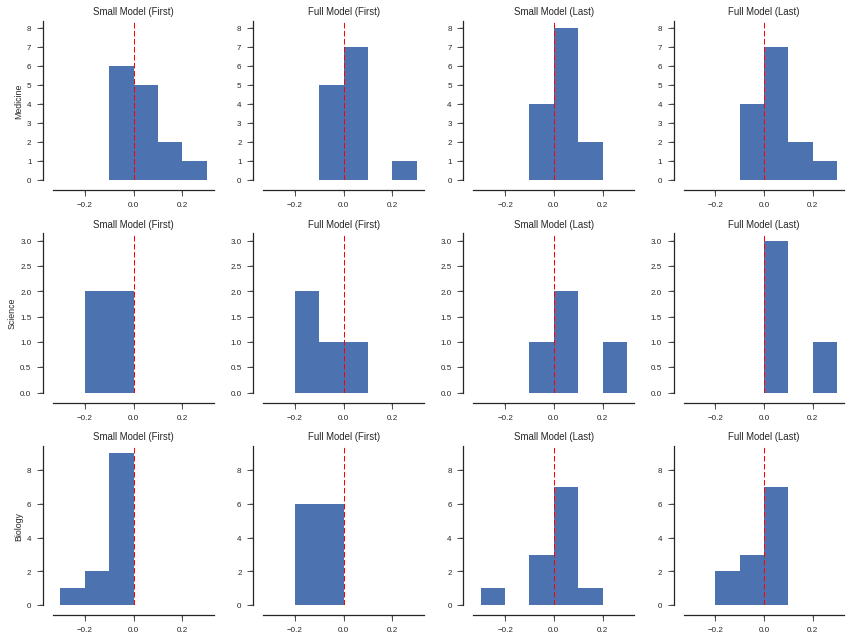

In [97]:
fig, ax = plt.subplots(3,4, sharex=True, sharey="row", figsize=(12,9))
bins=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]
for j, journal_cat in enumerate(set(df_journal_stats_all.index.get_level_values(0).tolist())):
    print journal_cat
    for i, title in enumerate(["First", "Last"]):
        df_journal_stats_all.reset_index(level=1).ix[
            journal_cat, (title, "beta")].plot(kind="hist", bins=bins, ax=ax[j, 2*i])
        df_journal_full_model_stats.reset_index(level=1).ix[
            journal_cat, (title, "beta")].plot(kind="hist", bins=bins, ax=ax[j, 2*i+1])
        ax[j, 2*i].set_title("Small Model ({})".format(title))
        ax[j, 2*i].axvline(x=0, color="r", linestyle="--", lw=1)
        ax[j, 2*i+1].set_title("Full Model ({})".format(title))
        ax[j, 2*i+1].axvline(x=0, color="r", linestyle="--", lw=1)
    ax[j, 0].set_ylabel(journal_cat)
sns.despine(offset=10)
fig.tight_layout()

In [98]:
sns.color_palette(["#ff0000", "#000000"])

[(1.0, 0.0, 0.0), (0.0, 0.0, 0.0)]

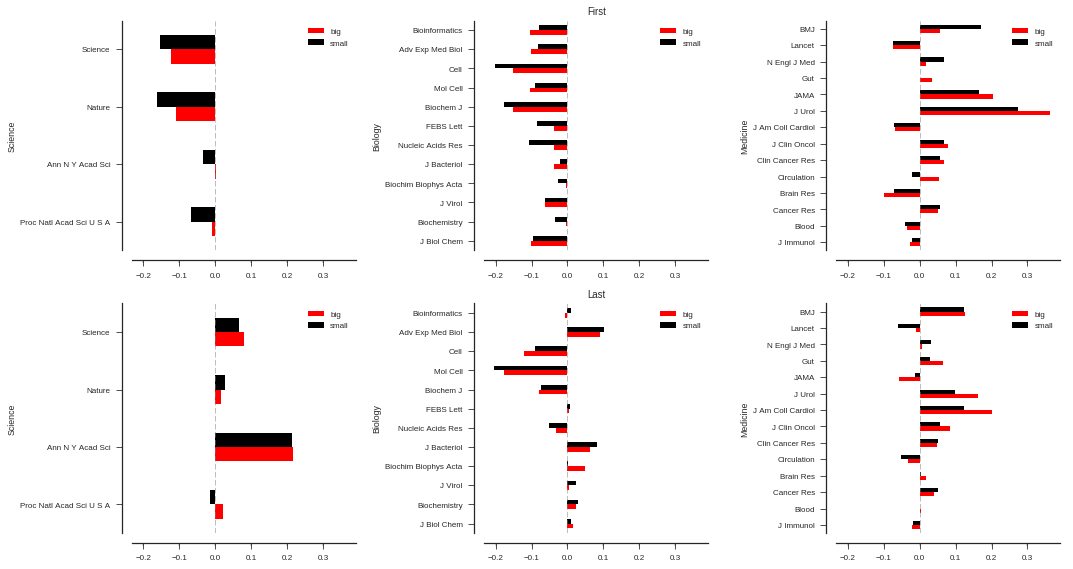

In [99]:
with sns.color_palette(["#ff0000", "#000000"]):
    fig, ax = plt.subplots(2,3, sharex=True, figsize=(15, 8))
    for i, title in enumerate(["First", "Last"]):
        for j, journal_name in enumerate(["Science", "Biology", "Medicine"]):
            pd.concat({
                "small": df_journal_stats_all.ix[journal_name,(title, "beta")],
                "big": df_journal_full_model_stats.ix[journal_name,(title, "beta")]
            }, axis=1).plot.barh(ax=ax[i,j])
            ax[i,j].set_ylabel(journal_name)
            ax[i,j].axvline(x=0, linestyle="--", color="0.5", linewidth=0.5)
        ax[i, 1].set_title(title)

    sns.despine(offset=10)
    fig.tight_layout()
    plt.savefig("Review_Figures/Journal_cat_betas_big_small.pdf", bbox_inches="tight")

## Indiv journal analysis

In [100]:
journal_model_formula = ("is_self_cite ~ "
            "I(auth_prev_papers == 0)"
           "+ I(auth_prev_papers == 1)"
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=['M', 'F'])"
           "+ C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           #"+ I(source_ncites == 1)"
           "+ np.log10(source_ncites)"
           "+ I(np.log10(source_ncites)**2) "#"+ I(np.log10(source_ncites)**3)"
           #"+ I(source_n_authors > 20)"
           #              " + np.log10(np.clip(source_n_authors, 0, 20))"
           #"+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + "#"I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0)"
                         " + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) "
                         "+ np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
            "+ I(match_prop == 0) + I(match_prop == 1) + match_prop + I(match_prop**2)"
          )

In [101]:
for journal_name in ["J Biol Chem"]:
    for i, (df_t_data, title) in enumerate(zip(
                    [df_t_first, df_t_last],
                    ["First", "Last"],
                )):
        print(title)
        model_stats = [np.nan, np.nan, np.nan]
        df_t_data = get_journal_data(df_t_data, journal_name).copy()
        #prepare_data(df_t_data)
        try:
            y_test, model = model_predictions(
                df_t_data, journal_model_formula,
                df_t_data.iloc[:3], verbose=False,
                model_params=dict(method='lbfgs', maxiter=100))
            display(model.summary2())
        except:
            print("Failed to fit")

First
('J Biol Chem', 171068)
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                           Results: Logit
====================================================================================================================================
Model:                                    Logit                                  Pseudo R-squared:                       0.234      
Dependent Variable:                       is_self_cite                           AIC:                                    179540.6798
Date:                                     2017-08-17 12:10                       BIC:                                    180294.7442
No. Observations:                         676859                                 Log-Likelihood:                         -89704.    
Df Model:                                 65                                     LL-Null:                                -1.1704e+05
Df Residuals:                             676793                                 LLR p-value:                            0.0000     
Converged:                                0.0000                                 Scale:                                  1.0000     
------------------------------------------------------------------------------------------------------------------------------------
                                                                      Coef.    Std.Err.      z     P>|z|      [0.025       0.975]   
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            -1.1151 1014742.2815  -0.0000 1.0000 -1988859.4405 1988857.2103
I(auth_prev_papers == 0)[T.True]                                     -0.3155       0.3863  -0.8168 0.4140       -1.0726       0.4416
I(auth_prev_papers == 1)[T.True]                                     -0.0406       0.0391  -1.0381 0.2992       -0.1171       0.0360
C(gender, levels=['M', 'F'])[T.F]                                    -0.0968       0.0143  -6.7576 0.0000       -0.1249      -0.0688
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.1516       0.2209  -0.6863 0.4925       -0.5845       0.2813
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.1262       0.0301  -4.1859 0.0000       -0.1853      -0.0671
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.2444       0.0374   6.5406 0.0000        0.1712       0.3177
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                 0.1017       0.0331   3.0733 0.0021        0.0368       0.1665
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.0219       0.0387  -0.5650 0.5721       -0.0977       0.0540
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                   0.1600       0.0554   2.8902 0.0038        0.0515       0.2685
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                  0.0903       0.0314   2.8797 0.0040        0.0288       0.1518
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.3567       0.2333  -1.5287 0.1263       -0.8141       0.1006
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]              -0.0291       0.0478  -0.6078 0.5434       -0.1228       0.0647
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                   0.1367       0.0545   2.5102 0.0121        0.0300       0.2434
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]             0.1273       0.0658   1.9354 0.0529       -0.0016       0.2562
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                  0.0434       0.0543   0.7994 0.4241       -0.0630       0.1498
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                   0.2383       0.1171   2.0358 0.0418        0.0089       0.4677
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                   0.0448       0.0246   1.8203 0.0687       -0.0034       0.0930
I(sink_n_mesh_ex == 

Last
('J Biol Chem', 171068)
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                   Results: Logit
=====================================================================================================================
Model:                               Logit                             Pseudo R-squared:                  0.096      
Dependent Variable:                  is_self_cite                      AIC:                               554395.4400
Date:                                2017-08-17 12:12                  BIC:                               555157.0251
No. Observations:                    758553                            Log-Likelihood:                    -2.7713e+05
Df Model:                            65                                LL-Null:                           -3.0642e+05
Df Residuals:                        758487                            LLR p-value:                       0.0000     
Converged:                           0.0000                            Scale:                             1.0000     
---------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                                            -1.0288      nan      nan    nan     nan     nan
I(auth_prev_papers == 0)[T.True]                                     -0.2344   1.0262  -0.2284 0.8193 -2.2457  1.7768
I(auth_prev_papers == 1)[T.True]                                     -0.1873   0.1806  -1.0368 0.2998 -0.5413  0.1668
C(gender, levels=['M', 'F'])[T.F]                                     0.0079   0.0099   0.7957 0.4262 -0.0115  0.0273
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.0486   0.1286  -0.3780 0.7054 -0.3007  0.2034
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.0829   0.0154  -5.3700 0.0000 -0.1132 -0.0526
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                  -0.2183   0.0331  -6.5893 0.0000 -0.2832 -0.1534
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                -0.0776   0.0188  -4.1269 0.0000 -0.1145 -0.0408
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.2002   0.0229  -8.7309 0.0000 -0.2452 -0.1553
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                  -0.2002   0.0314  -6.3652 0.0000 -0.2618 -0.1385
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                  0.0199   0.0161   1.2323 0.2178 -0.0117  0.0514
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.0940   0.0746  -1.2612 0.2072 -0.2402  0.0521
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]              -0.1661   0.0269  -6.1854 0.0000 -0.2188 -0.1135
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                  -0.0066   0.0328  -0.2024 0.8396 -0.0709  0.0576
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]            -0.0523   0.0391  -1.3355 0.1817 -0.1290  0.0244
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                 -0.1117   0.0309  -3.6108 0.0003 -0.1724 -0.0511
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.1204   0.0620  -1.9428 0.0520 -0.2419  0.0011
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                  -0.0602   0.0140  -4.3050 0.0000 -0.0877 -0.0328
I(sink_n_mesh_ex == 0)[T.True]                                       -0.1592   0.1078  -1.4765 0.1398 -0.3704  0.0521
I(year_span < 0)[T.True]                                              0.0014   0.6576   0.0022 0.9983 -1.2875  1.2903
I(year_span == 0)[T.True]                                             0.5991   0.0289  20.7070 0.0000  0.5424  0.6558
I(sink_prev_ncites == 0)[T.True]                                      0.3229   0.0218  14.8031 0.0000  0.2802

In [102]:
df_journal_full_model_stats[
    (df_journal_full_model_stats[("Last", "p-value")] < 0.05)
    #& (df_journal_full_model_stats[("Last", "beta")] > 0)
]

Author Position                First                                    \
                           citations      beta    stderr       p-value   
         Journal                                                         
Biology  J Bacteriol          102012 -0.037663  0.033765  2.646655e-01   
         Biochem J             91576 -0.152946  0.036076  2.239402e-05   
         Mol Cell              33538 -0.105273  0.068364  1.235868e-01   
         Cell                  32399 -0.151300  0.076033  4.659994e-02   
Medicine J Clin Oncol          61722  0.077715  0.041989  6.419382e-02   
         J Am Coll Cardiol     50523 -0.068152  0.061966  2.714106e-01   
         J Urol                49314  0.363535  0.065951  3.543983e-08   
Science  Ann N Y Acad Sci      52540  0.003086  0.034389  9.285022e-01   

Author Position                 Last                                    
                           citations      beta    stderr       p-value  
         Journal                                                        
Biology  J Bacteriol          109737  0.063241  0.022894  5.739561e-03  
         Biochem J             97174 -0.079645  0.027055  3.241796e-03  
         Mol Cell              39524 -0.176283  0.045367  1.020336e-04  
         Cell                  37042 -0.122344  0.050564  1.553732e-02  
Medicine J Clin Oncol          62049  0.085109  0.041894  4.219990e-02  
         J Am Coll Cardiol     52579  0.202210  0.057868  4.752258e-04  
         J Urol                50379  0.162318  0.064427  1.175524e-02  
Science  Ann N Y Acad Sci      54224  0.216270  0.035162  7.713824e-10

In [103]:
print("Journal with both first and last authorships having significant gender effect.")
df_journal_full_model_stats[
    (df_journal_full_model_stats[("Last", "p-value")] < 0.05)
    #& (df_journal_full_model_stats[("Last", "beta")] > 0)
    & (df_journal_full_model_stats[("First", "p-value")] < 0.05)
    #& (df_journal_full_model_stats[("First", "beta")] > 0)
]

Journal with both first and last authorships having significant gender effect.


Author Position        First                                        Last  \
                   citations      beta    stderr       p-value citations   
         Journal                                                           
Biology  Biochem J     91576 -0.152946  0.036076  2.239402e-05     97174   
         Cell          32399 -0.151300  0.076033  4.659994e-02     37042   
Medicine J Urol        49314  0.363535  0.065951  3.543983e-08     50379   

Author Position                                   
                        beta    stderr   p-value  
         Journal                                  
Biology  Biochem J -0.079645  0.027055  0.003242  
         Cell      -0.122344  0.050564  0.015537  
Medicine J Urol     0.162318  0.064427  0.011755